# Import dataset

In [1]:
import json
import pandas as pd
import re
import jieba 
import jieba.analyse
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from datetime import datetime
from imblearn.over_sampling import RandomOverSampler
import scipy.stats as stats


C:\Users\lenovo\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\lenovo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\lenovo\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [68]:
# show all comtents in df
# pd.set_option('display.max_colwidth', None)

# Restore to default settings
pd.reset_option('display.max_colwidth')

In [15]:
# import the depressed user dataset
with open('depressed.json', 'r') as file:
# Load the JSON data
    depressed = json.load(file)

# Read the JSON file into a pandas DataFrame
df_depressed = pd.read_json('depressed.json')



In [3]:
# import the normal user dataset
with open('normal.json', 'r') as file:
    # Load the JSON data
    normal = json.load(file)

df_normal = pd.read_json('normal.json')
# normal user， label=0, has errors, need to update
df_normal['label'] = 0

In [69]:
df_depressed.head(2)

,label,nickname,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count,tweets
0,1,迷失路径,男,此人严重丧，不适绕行，谢谢,1993-12-10,1,0,10,10,0,"[{'tweet_content': '有点累想休息了', 'posting_time': ..."
1,1,九七97吖,女,无,1997-06-07,173,76,219,79,70,"[{'tweet_content': '轉發微博', 'posting_time': '20..."


df_normal.head(2)

In [6]:
# save to csv
# df_depressed.to_csv('df_depressed.csv', index=False, encoding='utf-8')
# df_normal.to_csv('df_normal.csv', index=False, encoding='utf-8')

In [64]:
# read csv
# df_normal = pd.read_csv('df_normal.csv')
df_depressed = pd.read_csv('df_depressed.csv')

# Insert ID

Because there isn’t an ID column in the dataset, insert an ID for every user to identify records for future data process.

In [66]:
df_depressed = df_depressed.reset_index().rename(columns={'index': 'ID'})
df_depressed['ID'] += 1

In [67]:
df_normal = df_normal.reset_index().rename(columns={'index': 'ID'})
df_normal['ID'] += 1

In [66]:
df_depressed.head(2)

label nickname gender        profile    birthday  num_of_follower  \
0      1     迷失路径      男  此人严重丧，不适绕行，谢谢  1993-12-10                1   
1      1    九七97吖      女              无  1997-06-07              173   

   num_of_following  all_tweet_count  original_tweet_count  \
0                 0               10                    10   
1                76              219                    79   

   repost_tweet_count  \
0                   0   
1                  70   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [70]:
# Filter the DataFrame based on the 'nickname' column
# filtered_df = df_depressed[df_depressed['nickname'] == '迷失路径']

# Display the complete contents of the 'tweets' column for the filtered DataFrame
# for tweet in filtered_df['tweets']:
#    print(tweet)

In [71]:
df_normal.head(2)

,ID,label,nickname,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count,tweets
0,1,0,汤圆s点点滴滴,女,小日常,无,3,23,44,43,1,"[{'tweet_content': '酸汤肥牛底下还有你家的豆皮', 'posting_t..."
1,2,0,心无挂碍wxq,女,传播正能量，广结善缘。每天懂一点佛学知识，感悟人生，净化身心，弘扬佛法，传播中国传统文化，便...,2000-08-02,581,968,2877,98,0,"[{'tweet_content': '无', 'posting_time': '2020-..."


# Data balance

原始数据集中,男:女=7924:24646=1:3.2, 男女比例失衡。如果按照一般方法做数据平衡也会存在性别失衡的问题。Label 0: label 1= 22245: 10325= 2.2:1.  Label 为1的数据比label为0的数据要多了一半左右，并且在label为0的数据中，gender为女的数据是gender为男的数据的两倍。因此，在做数据平衡时，label为1的数据不动，label 为0且gender为男的数据也不动，在label 为0 但是gender为女的数据集中，随机取5000（7726+2599-5325=5000）行，构成新的数据集，此方法可以在保证数据平衡的条件下，减少男女比例差距，将男：女=1:3.2, 缩小至男：女=1:1.6。
原始数据集中，label和gender分组结果如图所示：男:女=7924:24646=1:3.2
一般方法做数据平衡后，label和gender分组如图所示：男:女= 5041:15609= 1：3.1，与原始数据集一样，同样存在性别失衡的情况。
按照新方法做数据平衡后，label和gender分组如图所示：男：女= 7924:12726= 1:1.6，将比例为1:3降低至1:1.6可减少男女比例之间的差距。


In [27]:
# data balance method2

df_merged1 = pd.read_csv('df_normal users and depressed users all columns.csv')

In [5]:
# before balance1
grouped_label = df_merged1.groupby(['label', ]).size().reset_index(name='count')

In [6]:
grouped_label

,label,count
0,0,22245
1,1,10325


In [7]:
grouped_gender = df_merged1.groupby(['gender', ]).size().reset_index(name='count')

In [8]:
grouped_gender

,gender,count
0,女,24646
1,男,7924


In [137]:

# Select random 5000 rows where label = 0 and gender = "女"

df_female = df_merged1[(df_merged1['label'] == 0) & (df_merged1['gender'] == '女')].sample(n=5000, random_state=42)

# Select all rows where label = 0 and gender = "男"
df_male = df_merged1[(df_merged1['label'] == 0) & (df_merged1['gender'] == '男')]

# Select all rows where label = 1
df_label_1 = df_merged1[df_merged1['label'] == 1]

# Merge all three parts of rows
df_final_balanced_all = pd.concat([df_female, df_male, df_label_1])


In [138]:
df_final_balanced_all

,ID,label,nickname,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count,tweets
25639,25640,0,南琅子柒,女,很会害羞,水瓶座,413,1672,3634,50,32,"[{'tweet_content': '冲', 'posting_time': '2020-..."
28302,28303,0,en嗯en_怪好,女,我想去一个地方、和你或者是自己看风吹麦浪,无,488,145,1969,41,57,[{'tweet_content': '拥抱是这个世界上最暖心的动作吧 生活中难免遇到挫折 ...
10545,10546,0,寒暑假常回家看看,女,一诚抵万恶,2000-04-26,135,797,148,65,25,"[{'tweet_content': '下雨天别穿max97 会滑倒 坐水里 亲测', 'p..."
26928,26929,0,CC-wang,女,若你喜欢怪人 那我也还不错,无,4913,251,712,100,1,[{'tweet_content': '有一种幸福～叫做一桌菜然后看着家人朋友满足的吃完 就...
31079,31080,0,私黛婷婷D女郎,女,专业丰胸私护达人+卫❤️：tingting395506,1987-10-23,336670,1126,9999,100,0,"[{'tweet_content': '无', 'posting_time': '2020-..."
...,...,...,...,...,...,...,...,...,...,...,...,...
10320,10321,1,LLLKti,男,无,无,24,2,96,94,2,[{'tweet_content': '自己不经意做的一件错事 我真的可以很久很久原谅不了自...
10321,10322,1,不期而遇的sunlight,女,🆕,双子座,145,501,2519,21,5,[{'tweet_content': '太喜欢张教授了说话特别实在从来不危言耸听当然整体来说...
10322,10323,1,MetyouinMay,女,无,0000-12-03,345,1003,4218,28,1,[{'tweet_content': '哪种毒药断送你的爱常常听说爱情是蜜糖深陷其中的人往往...
10323,10324,1,俎月可,男,教育！科学！学会读书，便是点燃火炬；每个字的每个音节都发射火星。,1981-08-16,243,307,148,24,2,"[{'tweet_content': '如果不能原谅一个人如何将自己的痛苦值降到最低', '..."


In [18]:
# Save final data to CSV file
df_final_balanced_all.to_csv('df_merged_balanced_all_columns.csv', index=False)

In [10]:
# data balance method2

df_final_balanced_all = pd.read_csv('df_merged_balanced_all_columns.csv')

In [11]:
# after data balance1, label
grouped_label = df_final_balanced_all.groupby(['label', ]).size().reset_index(name='count')

In [13]:
grouped_label

,label,count
0,0,10325
1,1,10325


In [12]:
# after data balance1,gender
grouped_gender = df_final_balanced_all.groupby(['gender', ]).size().reset_index(name='count')

In [14]:
grouped_gender

,gender,count
0,女,12726
1,男,7924


# Data selection

select ID, label and tweets

Due to there are 18 variables in the dataset and in tweets column, there are seven variables, which is not conductive to applying the model to do text classification. Extract ID, label, and tweets columns and generate to a new data frame. Save the new data frame to csv file for future use.

In [141]:
df_final_balanced_all= pd.read_csv('df_merged_balanced_all_columns.csv')

In [19]:
df_final_balanced_all2=df_final_balanced_all.copy()

In [ ]:
df_final_balanced_all2

In [149]:
df_final_balanced_all_tweets

,ID,label,tweet_content
0,25640,0,"[冲, 害 我真的挺吃lyw的颜 但一想到他只有14岁我就, 足以表达我减肥的决心了, 无,..."
1,28303,0,[拥抱是这个世界上最暖心的动作吧 生活中难免遇到挫折 坎坷 不安 在一个人慌乱的时候 也许有...
2,10546,0,"[下雨天别穿max97 会滑倒 坐水里 亲测, 我艾特曾子赟相信大家都不会有意见的对吧, 麻..."
3,26929,0,"[有一种幸福～叫做一桌菜然后看着家人朋友满足的吃完 就是没人帮忙刷碗, 老规矩, 昨晚本想做..."
4,31080,0,"[无, 无, 无, 无, 无, 无, 无, 无, 无, 无, 无, 无, 无, 无, 无, ..."
...,...,...,...
20645,10321,1,"[自己不经意做的一件错事 我真的可以很久很久原谅不了自己, 最近发生了好多事啊 我情绪波动很..."
20646,10322,1,[太喜欢张教授了说话特别实在从来不危言耸听当然整体来说我自己认识的医生我自己的亲戚朋友就医生...
20647,10323,1,[哪种毒药断送你的爱常常听说爱情是蜜糖深陷其中的人往往会沉醉不已岂知一份爱情它再美好也会因为...
20648,10324,1,"[如果不能原谅一个人如何将自己的痛苦值降到最低, 我现在贼后悔吃麻辣串 洗完澡新换的衣服全是..."


In [145]:
df_final_balanced_all_tweets = df_final_balanced_all2[['ID', 'label']].copy()

In [147]:
# Convert string representation of dictionaries to actual dictionaries
import ast
df_final_balanced_all2['tweets'] = df_final_balanced_all2['tweets'].apply(ast.literal_eval)

In [148]:
df_final_balanced_all_tweets['tweet_content'] = df_final_balanced_all2['tweets'].apply(lambda x: [d['tweet_content'] for d in x])


In [150]:
# after data balance1
grouped_label = df_final_balanced_all_tweets.groupby(['label', ]).size().reset_index(name='count')

In [151]:
grouped_label

,label,count
0,0,10325
1,1,10325


In [152]:
# Save final data to CSV file
df_final_balanced_all_tweets.to_csv('df_final_balanced_ID_label_tweets.csv', index=False)

# Data clean

In [42]:
balanced_df_all = pd.read_csv('df_final_balanced_ID_label_tweets.csv')

In [60]:
### 15649
balanced_df_all.loc[balanced_df_all['ID'] == 15649]

,ID,label,tweet_content
280,15649,0,"['无', '', '五月 一场急雨 大自然的神奇力量～', '❤️', '昨天发生的大无语事件 又被大家可爱到 但我真觉得这个邮箱挺难弄的', '认真记录生活点滴 一直在外面读书六年没看见家里的四月走在路上深呼吸感觉回到了初中时代', '无', '小朋友你是否有很多问号♀️', '断食三天效果一般 我现在要去弄个咖啡喝', '하루하루', '护肤千万条戒糖第一条～♀️', '疫情在家熬出来一个厨师내 고양이는 참 귀엽다茶叶喝完了下午要出门买 续命年前的火锅后悔没多吃几口 miss一起加油', '人间值得 微博视频', '难搞', '无', '', 'ᑋᵉᑊᑊᵒ ᵕ̈✨ ◡̈', '开开心心', '无', '丧一点都不酷努力生活才最酷', '生活值得', '分享不新鲜', '无', '无', '一周', '', '无', '☕️✨', '谢谢姐姐这两天一直陪着我 我会把身体变得棒棒的开开心心的', '无', '再坚持一下', '平安喜乐2019新年心愿', '今日分享 三毛如果你给我的和你给别人的是一样的那我就不要了', 'gracejijie的秒拍视频', '无', '晚安', '无', '又该减肥了 妈妈拍的照片真的懒得P', '比起舞蹈唱歌服装什么的 泫雅最撩的就是对镜能力没有比她做的更好的', '无', '现在充电宝有电就会让我觉的安心 好心情是自己给自己的 我觉的C家家不能挂 我除了半熟芝士买成榴莲味吃了一个感觉整个人都不好了其他哪都好', '历史最低的体重 终于下决心做了一次黑色的美甲 想做一个独立的人 想喝奶茶 想睡醒 想赶紧把测绘弄完 复习周快乐', '房间电影超时空同居插曲 时间一直向前我们不能改变什么', '无', '画画养猫 这样的生活我想过一辈子～', '无', '', '无', '爱你们 gracejijie的秒拍视频', '我要请哥哥姐姐来', '周末快乐', '', '❤️ 我的猫', '', '狗年快乐', '念', '我也是00后我要蹭热度', '无', '我们还没有一张合影呢', '无', '无', '无', '无', '无', '无']"


In [155]:
# Load stopwords
with open('merged_stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.read().splitlines()

In [162]:
def clean_text(text):
   
    # Remove numbers, emojis, punctuations,special charts,shared posts, hashtags
    # Only Chinese characters are reserved.
    text = re.sub(r'[^\u4e00-\u9fff]+', '', text)
    
    # Remove weibo stop words
    for word in stopwords:
        if word in text:
            text = re.sub(word, '', text)   
    return text

In [163]:
balanced_df_all_cleaned = balanced_df_all.copy()

In [164]:
balanced_df_all_cleaned.loc[:, 'tweet_content'] = balanced_df_all_cleaned['tweet_content'].apply(clean_text)

In [166]:
balanced_df_all_cleaned

,ID,label,tweet_content
0,25640,0,害真挺吃颜想岁足表达减肥决心姐妹谈恋爱感觉全世界闺蜜介绍成功行淦近新情侣装评手评寻思俩关系挺...
1,28303,0,拥抱世界暖心动作生活中难免挫折坎坷安慌乱许拥抱充满量世界抗衡愿生山树栖心爱春赏花夏纳凉秋登山...
2,10546,0,雨天穿滑倒坐水里亲测艾特子赟家意见麻雀妈妈问麻雀扎头发麻雀说啾啾晚子赟帮辫头发感找年糊图张回...
3,26929,0,幸福做桌菜然家朋友吃完没帮忙刷碗老规矩昨晚想做早餐奶包发酵忘遛弯回馒头样子朋友吃午两点吃早新...
4,31080,0,日清明青草疫情中牺牲医护员公安干警基层干部线工作逝世胞沉痛悼念情病毒面前选择逆行选择死生选择...
...,...,...,...
20645,10321,1,意做件错事真久久原谅近发生事情绪波动房间爆哭然雨天跑出外面冻两时爸妈姨表哥电话接妈妈外面找找...
20646,10322,1,太喜欢张教授说话特实危言耸听然整体医生亲戚朋友医生医生子女微博关注医生说话客观尤专业领域戴口...
20647,10323,1,毒药断送爱听说爱情蜜糖深陷沉醉岂知份爱情美意想原理结束意想称爱情毒药爱情终止测试图点外卖点外...
20648,10324,1,果原谅痛苦值降低贼悔吃麻辣串洗完澡新换衣服全味难受新闻男熬夜猝死死女抑郁症确诊天昨天加药量睡...


In [167]:
# save to csv
balanced_df_all_cleaned.to_csv('balanced_df_all_cleaned.csv', index=False, encoding='utf-8')

# Tokenization

## data cleaning>tokenization

In [22]:
balanced_df_all_cleaned = pd.read_csv('balanced_df_all_cleaned.csv')

In [24]:
balanced_df_all_cleaned.loc[balanced_df_all_cleaned['ID'] == 15649]

,ID,label,tweet_content
280,15649,0,五月场急雨然神奇力量昨天发生语事件家爱真觉邮箱挺难弄记录生活点滴外面读书六年没见家里四月走路深呼吸感觉回初中时代朋友否问号断食三天效果弄咖啡喝护肤千万条戒糖条疫情家熬厨师茶叶喝完午出门买续命年前火锅悔没吃口加油间值微博视频难搞开开心心丧点酷努力生活酷生活值分享新鲜周谢谢姐姐两天陪身体变棒棒开开心心平安喜乐新年心愿日分享三毛果秒拍视频晚安减肥妈妈拍片真懒舞蹈唱歌服装泫雅撩镜力没做更充电宝电觉安心心情觉家家挂半熟芝士买成榴莲味吃感觉整历史低体重终决心做黑色美甲想做独立想喝奶茶想睡醒想紧测绘弄完复习周快乐房间电影超时空居插曲时间前改变画画养猫样生活想辈子爱秒拍视频请哥哥姐姐周末快乐猫狗年快乐念蹭热度没张合影


In [169]:
balanced_df_all_cleaned

,ID,label,tweet_content
0,25640,0,害真挺吃颜想岁足表达减肥决心姐妹谈恋爱感觉全世界闺蜜介绍成功行淦近新情侣装评手评寻思俩关系挺...
1,28303,0,拥抱世界暖心动作生活中难免挫折坎坷安慌乱许拥抱充满量世界抗衡愿生山树栖心爱春赏花夏纳凉秋登山...
2,10546,0,雨天穿滑倒坐水里亲测艾特子赟家意见麻雀妈妈问麻雀扎头发麻雀说啾啾晚子赟帮辫头发感找年糊图张回...
3,26929,0,幸福做桌菜然家朋友吃完没帮忙刷碗老规矩昨晚想做早餐奶包发酵忘遛弯回馒头样子朋友吃午两点吃早新...
4,31080,0,日清明青草疫情中牺牲医护员公安干警基层干部线工作逝世胞沉痛悼念情病毒面前选择逆行选择死生选择...
...,...,...,...
20645,10321,1,意做件错事真久久原谅近发生事情绪波动房间爆哭然雨天跑出外面冻两时爸妈姨表哥电话接妈妈外面找找...
20646,10322,1,太喜欢张教授说话特实危言耸听然整体医生亲戚朋友医生医生子女微博关注医生说话客观尤专业领域戴口...
20647,10323,1,毒药断送爱听说爱情蜜糖深陷沉醉岂知份爱情美意想原理结束意想称爱情毒药爱情终止测试图点外卖点外...
20648,10324,1,果原谅痛苦值降低贼悔吃麻辣串洗完澡新换衣服全味难受新闻男熬夜猝死死女抑郁症确诊天昨天加药量睡...


In [ ]:
# dftest=balanced_df_all_cleaned_tokenization[(balanced_df_all_cleaned_tokenization['ID'] == 30838) | (balanced_df_all_cleaned_tokenization['ID'] == 24223)]

In [170]:
balanced_df_all_cleaned2 = balanced_df_all_cleaned.copy()

In [171]:
balanced_df_all_cleaned2

,ID,label,tweet_content
0,25640,0,害真挺吃颜想岁足表达减肥决心姐妹谈恋爱感觉全世界闺蜜介绍成功行淦近新情侣装评手评寻思俩关系挺...
1,28303,0,拥抱世界暖心动作生活中难免挫折坎坷安慌乱许拥抱充满量世界抗衡愿生山树栖心爱春赏花夏纳凉秋登山...
2,10546,0,雨天穿滑倒坐水里亲测艾特子赟家意见麻雀妈妈问麻雀扎头发麻雀说啾啾晚子赟帮辫头发感找年糊图张回...
3,26929,0,幸福做桌菜然家朋友吃完没帮忙刷碗老规矩昨晚想做早餐奶包发酵忘遛弯回馒头样子朋友吃午两点吃早新...
4,31080,0,日清明青草疫情中牺牲医护员公安干警基层干部线工作逝世胞沉痛悼念情病毒面前选择逆行选择死生选择...
...,...,...,...
20645,10321,1,意做件错事真久久原谅近发生事情绪波动房间爆哭然雨天跑出外面冻两时爸妈姨表哥电话接妈妈外面找找...
20646,10322,1,太喜欢张教授说话特实危言耸听然整体医生亲戚朋友医生医生子女微博关注医生说话客观尤专业领域戴口...
20647,10323,1,毒药断送爱听说爱情蜜糖深陷沉醉岂知份爱情美意想原理结束意想称爱情毒药爱情终止测试图点外卖点外...
20648,10324,1,果原谅痛苦值降低贼悔吃麻辣串洗完澡新换衣服全味难受新闻男熬夜猝死死女抑郁症确诊天昨天加药量睡...


In [172]:
balanced_df_all_cleaned2['tweet_content'] = balanced_df_all_cleaned2['tweet_content'].astype(str)

In [173]:
balanced_df_all_cleaned2['tweet_content'] = balanced_df_all_cleaned2['tweet_content'].apply(lambda x: ' '.join(jieba.cut(x)))

In [174]:
balanced_df_all_cleaned2

,ID,label,tweet_content
0,25640,0,害真 挺 吃 颜想 岁 足 表达 减肥 决心 姐妹 谈恋爱 感觉 全世界 闺蜜 介绍 成功 ...
1,28303,0,拥抱 世界 暖心 动作 生活 中 难免 挫折 坎坷 安 慌乱 许 拥抱 充满 量 世界 抗衡...
2,10546,0,雨天 穿 滑倒 坐水里 亲测 艾特子 赟 家 意见 麻雀 妈妈 问 麻雀 扎 头发 麻雀 说...
3,26929,0,幸福 做 桌菜 然家 朋友 吃 完 没 帮忙 刷碗 老规矩 昨晚 想 做 早餐 奶包 发酵 ...
4,31080,0,日 清明 青草 疫情 中 牺牲 医护 员 公安干警 基层干部 线 工作 逝世 胞 沉痛 悼念...
...,...,...,...
20645,10321,1,意做件 错事 真 久久 原谅 近 发生 事 情绪 波动 房间 爆哭然 雨天 跑 出 外面 冻...
20646,10322,1,太 喜欢 张 教授 说话 特实 危言耸听 然 整体 医生 亲戚朋友 医生 医生 子女 微博 ...
20647,10323,1,毒药 断送 爱 听说 爱情 蜜糖 深陷 沉醉 岂知 份 爱情 美意 想 原理 结束 意想 称...
20648,10324,1,果 原谅 痛苦 值 降低 贼 悔 吃 麻辣 串 洗完 澡 新 换衣服 全味 难受 新闻 男 ...


In [175]:
# save to csv
balanced_df_all_cleaned2.to_csv('balanced_df_all_cleaned_tokenization.csv', index=False, encoding='utf-8')

# Feature extraction (Start here)

TF-IDF

In [25]:
balanced_df_all_cleaned_tokenization = pd.read_csv('balanced_df_all_cleaned_tokenization.csv')

In [26]:
balanced_df_all_cleaned_tokenization.loc[balanced_df_all_cleaned_tokenization['ID'] == 15649]

,ID,label,tweet_content
280,15649,0,五月 场 急雨然 神奇 力量 昨天 发生 语 事件 家爱 真觉 邮箱 挺难 弄 记录 生活 点滴 外面 读书 六年 没 见 家里 四月 走路 深呼吸 感觉 回 初中 时代 朋友 否 问号 断食 三天 效果 弄 咖啡 喝 护肤 千万条 戒糖条 疫情 家熬 厨师 茶叶 喝完 午 出门 买 续命 年前 火锅 悔 没吃口 加油 间值 微博 视频 难搞 开开心心 丧点酷 努力 生活 酷 生活 值 分享 新鲜 周 谢谢 姐姐 两天 陪 身体 变 棒棒 开开心心 平安 喜乐 新年 心愿 日 分享 三毛 果秒 拍 视频 晚安 减肥 妈妈 拍片 真懒 舞蹈 唱歌 服装 泫 雅 撩 镜力 没 做 更 充电 宝电觉 安心 心情 觉 家家 挂 半熟 芝士 买 成 榴莲 味 吃 感觉 整 历史 低 体重 终 决心 做 黑色 美甲 想 做 独立 想 喝 奶茶 想 睡醒 想紧 测绘 弄完 复习 周 快乐 房间 电影 超时空 居 插曲 时间 前 改变 画画 养猫 样 生活 想 辈子 爱 秒 拍 视频 请 哥哥 姐姐 周末 快乐 猫 狗 年 快乐 念 蹭 热度 没张 合影


In [239]:
balanced_df_all_cleaned_tokenization

,ID,label,tweet_content
0,25640,0,害真 挺 吃 颜想 岁 足 表达 减肥 决心 姐妹 谈恋爱 感觉 全世界 闺蜜 介绍 成功 ...
1,28303,0,拥抱 世界 暖心 动作 生活 中 难免 挫折 坎坷 安 慌乱 许 拥抱 充满 量 世界 抗衡...
2,10546,0,雨天 穿 滑倒 坐水里 亲测 艾特子 赟 家 意见 麻雀 妈妈 问 麻雀 扎 头发 麻雀 说...
3,26929,0,幸福 做 桌菜 然家 朋友 吃 完 没 帮忙 刷碗 老规矩 昨晚 想 做 早餐 奶包 发酵 ...
4,31080,0,日 清明 青草 疫情 中 牺牲 医护 员 公安干警 基层干部 线 工作 逝世 胞 沉痛 悼念...
...,...,...,...
20645,10321,1,意做件 错事 真 久久 原谅 近 发生 事 情绪 波动 房间 爆哭然 雨天 跑 出 外面 冻...
20646,10322,1,太 喜欢 张 教授 说话 特实 危言耸听 然 整体 医生 亲戚朋友 医生 医生 子女 微博 ...
20647,10323,1,毒药 断送 爱 听说 爱情 蜜糖 深陷 沉醉 岂知 份 爱情 美意 想 原理 结束 意想 称...
20648,10324,1,果 原谅 痛苦 值 降低 贼 悔 吃 麻辣 串 洗完 澡 新 换衣服 全味 难受 新闻 男 ...


In [240]:
balanced_df_all_cleaned_tokenization2 = balanced_df_all_cleaned_tokenization.copy()

In [241]:
# replace NaN values with an empty string
balanced_df_all_cleaned_tokenization2['tweet_content'] = balanced_df_all_cleaned_tokenization2['tweet_content'].fillna('')

In [242]:
# create a TfidfVectorizer object 将tweet_content列作为特征向量化
vectorizer = TfidfVectorizer()

In [243]:
vectorizer

TfidfVectorizer()

In [244]:
# fit and transform the data
X = vectorizer.fit_transform(balanced_df_all_cleaned_tokenization2['tweet_content'])

In [9]:
X

<20650x944640 sparse matrix of type '<class 'numpy.float64'>'
	with 10459427 stored elements in Compressed Sparse Row format>

In [52]:
# get the feature names, # 得到语料库所有不重复的词
# print(vectorizer.get_feature_names_out() )

In [245]:
# 将label列作为目标变量
y = balanced_df_all_cleaned_tokenization2['label']

save to txt

with open('feature_names.txt', 'w') as f:
    for item in vectorizer.get_feature_names_out():
        f.write("%s\n" % item)


# models

## Split the dataset into training and test sets

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Random Forest

In [247]:
# 训练随机森林模型
rfc = RandomForestClassifier(n_estimators=13) # 修改树的棵树， 使用10折交叉验证来确定n_estimators的最佳值为13
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=13)

In [248]:
# 预测测试集的label
y_pred_rfc = rfc.predict(X_test)

In [249]:
# 计算模型评估指标
accuracy_rf = accuracy_score(y_test, y_pred_rfc)
precision_rf = precision_score(y_test, y_pred_rfc)
recall_rf = recall_score(y_test, y_pred_rfc)
f1_rf = f1_score(y_test, y_pred_rfc)

print('Accuracy:', accuracy_rf)
print('Precision:', precision_rf)
print('Recall:', recall_rf)
print('F1 Score:', f1_rf)

Accuracy: 0.9154156577885392
Precision: 0.9351513136015963
Recall: 0.8952562878064311
F1 Score: 0.91476903057905


In [250]:
# normal content
new_tweet_content = ['这是 一条 新的 正常 推文']

# depressed content
# new_tweet_content = ['思 诺思 舒乐安定 代开 疫情 期间 开药 困难 开药 断药 关注 南京 兼职 超话志道 合盆友 解释 快 超话 传送门 南京 兼职']

# feature extraction
new_X = vectorizer.transform(new_tweet_content)

# RF
new_y_pred_rfc = rfc.predict(new_X)

print('\nnew_tweet_content label:')
print('RF:', new_y_pred_rfc)


new_tweet_content label:
RF: [0]


## SVM

In [213]:
# 训练SVM模型
svc = SVC(kernel='linear')
svc.fit(X_train, y_train)

SVC(kernel='linear')

In [214]:
# 预测测试集的label
y_pred_svc = svc.predict(X_test)

In [215]:
# 计算SVM模型评估指标
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)

print('\nSupport Vector Machine:')
print('Accuracy:', accuracy_svc)
print('Precision:', precision_svc)
print('Recall:', recall_svc)
print('F1 Score:', f1_svc)


Support Vector Machine:
Accuracy: 0.947861178369653
Precision: 0.9874520738933427
Recall: 0.9080128205128205
F1 Score: 0.9460677909500752


In [216]:
# normal content
# new_tweet_content = ['这是 一条 新的 正常 推文']

# depressed content
new_tweet_content = ['思 诺思 舒乐安定 代开 疫情 期间 开药 困难 开药 断药 关注 南京 兼职 超话志道 合盆友 解释 快 超话 传送门 南京 兼职']

# feature extraction
new_X = vectorizer.transform(new_tweet_content)

# SVM
new_y_pred_svc = svc.predict(new_X)

print('\nnew_tweet_content label:')
print('SVM:', new_y_pred_svc)


new_tweet_content label:
SVM: [1]


In [199]:
# normal content
# new_tweet_content = ['这是 一条 新的 正常 推文']

# depressed content
new_tweet_content = ['思 诺思 舒乐安定 代开 疫情 期间 开药 困难 开药 断药 关注 南京 兼职 超话志道 合盆友 解释 快 超话 传送门 南京 兼职']

# feature extraction
new_X = vectorizer.transform(new_tweet_content)

# SVM
new_y_pred_svc = svc.predict(new_X)
new_y_pred_rfc = rfc.predict(new_X)

print('\nnew_tweet_content label:')
print('SVM:', new_y_pred_svc)
print('RF:', new_y_pred_rfc)


new_tweet_content label:
SVM: [1]
RF: [1]


## MLP

In [221]:
mlp = MLPClassifier(hidden_layer_sizes=(30,), max_iter=20,batch_size=128)

adam： Kingma, Diederik, and Jimmy Ba提出的机遇随机梯度的优化器 注意：默认solver ‘adam’在相对较大的数据集上效果比较好.
early_stopping : bool, default False,Only effective when solver=’sgd’ or ‘adam’,判断当验证效果不再改善的时候是否终止训练，当为True时，自动选出10%的训练数据用于验证并在两步连续爹迭代改善低于tol时终止训练.batchsize并非越大越好，一个经验性的可选数值是32、64、128，一般来说，每个batch的大小一旦超过64，继续增大batch带来的性能收益就微乎其微了

In [222]:
mlp.fit(X_train, y_train)

C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=128, hidden_layer_sizes=(30,), max_iter=20)

我使用RandomizedSearchCV搜索最佳超参数组合。GridSearchCV和RandomizedSearchCV都是用于超参数调优的方法，但它们的实现方式不同。GridSearchCV会遍历所有可能的参数组合，而RandomizedSearchCV则会随机选择一些参数组合进行训练。当数据集较小时，我们可以使用GridSearchCV，但当数据集较大时，我们可以使用RandomizedSearchCV

Best parameters: {'solver': 'adam', 'max_iter': 1500, 'hidden_layer_sizes': (100,), 'activation': 'relu'}
Best cross-validation score: 0.90
用100条数据进行测试， 50条0,50条1

In [223]:
# 预测测试集的label
y_pred_mlp = mlp.predict(X_test)

In [224]:
# 计算MLP模型评估指标
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

In [225]:
print('\nMulti-layer Perceptron:')
print('Accuracy:', accuracy_mlp)
print('Precision:', precision_mlp)
print('Recall:', recall_mlp)
print('F1 Score:', f1_mlp)



Multi-layer Perceptron:
Accuracy: 0.9394673123486683
Precision: 0.9705176551251286
Recall: 0.9073717948717949
F1 Score: 0.9378830544972668


In [226]:
# 将新的tweet_content转换为特征向量
# new_tweet_content = ['这是 一条 新的 正常 推文']

# depressed content
new_tweet_content = ['思 诺思 舒乐安定 代开 疫情 期间 开药 困难 开药 断药 关注 南京 兼职 超话志道 合盆友 解释 快 超话 传送门 南京 兼职']


# feature extraction
new_X = vectorizer.transform(new_tweet_content)

# 使用MLP模型进行预测
new_y_pred_mlp = mlp.predict(new_X)

print('MLP模型:', new_y_pred_mlp)

MLP模型: [1]


## TextCNN

In [2]:
# Load the dataset
balanced_df_all_cleaned_tokenization = pd.read_csv('balanced_df_all_cleaned.csv')
# tokenization：balanced_df_all_cleaned_tokenization
# no tokenization: balanced_df_all_cleaned

In [3]:
balanced_df_all_cleaned_tokenization['tweet_content'] = balanced_df_all_cleaned_tokenization['tweet_content'].fillna('')

In [4]:
df3=balanced_df_all_cleaned_tokenization.copy()

In [5]:
df3.head()

,ID,label,tweet_content
0,25640,0,害真挺吃颜想岁足表达减肥决心姐妹谈恋爱感觉全世界闺蜜介绍成功行淦近新情侣装评手评寻思俩关系挺...
1,28303,0,拥抱世界暖心动作生活中难免挫折坎坷安慌乱许拥抱充满量世界抗衡愿生山树栖心爱春赏花夏纳凉秋登山...
2,10546,0,雨天穿滑倒坐水里亲测艾特子赟家意见麻雀妈妈问麻雀扎头发麻雀说啾啾晚子赟帮辫头发感找年糊图张回...
3,26929,0,幸福做桌菜然家朋友吃完没帮忙刷碗老规矩昨晚想做早餐奶包发酵忘遛弯回馒头样子朋友吃午两点吃早新...
4,31080,0,日清明青草疫情中牺牲医护员公安干警基层干部线工作逝世胞沉痛悼念情病毒面前选择逆行选择死生选择...


In [6]:
# Preprocess the data
X = df3['tweet_content']
y = df3['label']

In [7]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [8]:
# Tokenize the sequences using Jieba tokenizer
def tokenize(text):
    return list(jieba.cut(text))
X_train_sequences = [' '.join(tokenize(x)) for x in X_train]
X_test_sequences = [' '.join(tokenize(x)) for x in X_test]


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.881 seconds.
Prefix dict has been built successfully.


In [9]:
# Convert tokens to integer sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_sequences)

# Convert tokenized sequences to integer sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train_sequences)
X_test_sequences = tokenizer.texts_to_sequences(X_test_sequences)

In [10]:
# Pad sequences
max_sequence_length = 7000  # Set the maximum sequence length for padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


In [11]:
print(X_test_padded.shape)

(6195, 7000)


In [12]:
# Define the model architecture
embedding_dim = 100
num_filters = 100
filter_sizes = [3, 4, 5]

inputs = tf.keras.Input(shape=(max_sequence_length,))
embedding_layer = tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)(inputs)
conv_layers = []
for filter_size in filter_sizes:
    conv_layer = tf.keras.layers.Conv1D(num_filters, filter_size, activation='relu')(embedding_layer)
    pool_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
    conv_layers.append(pool_layer)
concatenated = tf.keras.layers.Concatenate()(conv_layers)
dropout = tf.keras.layers.Dropout(0.5)(concatenated)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dropout)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test))

# Evaluate the model
y_pred = model.predict(X_test_padded)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Epoch 1/10
452/452 [==============================] - 484s 1s/step - loss: 0.2192 - accuracy: 0.9102 - val_loss: 0.1040 - val_accuracy: 0.9622
Epoch 2/10
452/452 [==============================] - 463s 1s/step - loss: 0.0756 - accuracy: 0.9740 - val_loss: 0.0955 - val_accuracy: 0.9674
Epoch 3/10
452/452 [==============================] - 447s 990ms/step - loss: 0.0266 - accuracy: 0.9920 - val_loss: 0.1072 - val_accuracy: 0.9627
Epoch 4/10
452/452 [==============================] - 455s 1s/step - loss: 0.0088 - accuracy: 0.9981 - val_loss: 0.1018 - val_accuracy: 0.9653
Epoch 5/10
452/452 [==============================] - 458s 1s/step - loss: 0.0032 - accuracy: 0.9995 - val_loss: 0.1181 - val_accuracy: 0.9643
Epoch 6/10
452/452 [==============================] - 457s 1s/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.1187 - val_accuracy: 0.9676
Epoch 7/10
452/452 [==============================] - 455s 1s/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 0.1291 - val_accuracy: 0.9

## Save models

In [168]:
# import pickle

### SVM

In [218]:
# 保存模型
with open('svm_whole2.pkl', 'wb') as file:
    pickle.dump(svc, file)


In [132]:
# 模型读取
with open('svm_whole2.pkl', 'rb') as file:
    svc = pickle.load(file)

### MLP

In [227]:
# 保存模型
with open('mlp_whole2.pkl', 'wb') as file:
    pickle.dump(mlp, file)

In [93]:
# 模型读取
with open('mlp_whole2.pkl', 'rb') as file:
    mlp = pickle.load(file)

### RF

In [251]:
# 保存模型
with open('rf_whole2.pkl', 'wb') as file:
    pickle.dump(rfc, file)

In [69]:
# 模型读取
with open('rf_whole2.pkl', 'rb') as file:
    rfc = pickle.load(file)

### TextCNN

In [13]:
# Save the model using model.save() # use this method
model.save('TextCNN_0807whole.h5')


In [ ]:

# Load the model
loaded_model = tf.keras.models.load_model('TextCNN_0807test2007.h5')


In [299]:
# Save the model, don't use this method, after loading the model, the acc is low
tf.saved_model.save(model, 'TextCNN_whole2')

INFO:tensorflow:Assets written to: TextCNN_whole2\assets


INFO:tensorflow:Assets written to: TextCNN_whole2\assets


In [ ]:
# Load the model
loaded_model = tf.saved_model.load('TextCNN_whole2')

# load and use models

## RF, SVM, MLP

### 模型使用 after feature extraction and split the dataset, start here, no textCNN

In [2]:
balanced_df_all_cleaned_tokenization = pd.read_csv('balanced_df_all_cleaned_tokenization.csv')
balanced_df_all_cleaned_tokenization2 = balanced_df_all_cleaned_tokenization.copy()
# replace NaN values with an empty string
balanced_df_all_cleaned_tokenization2['tweet_content'] = balanced_df_all_cleaned_tokenization2['tweet_content'].fillna('')
# create a TfidfVectorizer object 将tweet_content列作为特征向量化
vectorizer = TfidfVectorizer()
# fit and transform the data
X = vectorizer.fit_transform(balanced_df_all_cleaned_tokenization2['tweet_content'])
# 将label列作为目标变量
y = balanced_df_all_cleaned_tokenization2['label']
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [3]:
#rf
with open('rf_whole2.pkl', 'rb') as file:
    rfc = pickle.load(file)

# svm
with open('svm_whole2.pkl', 'rb') as file:
    svc = pickle.load(file)

# mlp    
with open('mlp_whole2.pkl', 'rb') as file:
    mlp = pickle.load(file)

In [4]:
# Evaluation
y_pred_rfc = rfc.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_mlp = mlp.predict(X_test)

In [5]:
rfc_accuracy = accuracy_score(y_test, y_pred_rfc)
rfc_precision = precision_score(y_test, y_pred_rfc)
rfc_recall = recall_score(y_test, y_pred_rfc)
rfc_f1 = f1_score(y_test, y_pred_rfc)

accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
precision_mlp = precision_score(y_test, y_pred_mlp)
recall_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)



In [6]:
print('\nRandom Forest:')
print('Accuracy:', rfc_accuracy)
print('Precision:', rfc_precision)
print('Recall:', rfc_recall)
print('F1 Score:', rfc_f1)

print('\nMulti-layer Perceptron:')
print('Accuracy:', accuracy_mlp)
print('Precision:', precision_mlp)
print('Recall:', recall_mlp)
print('F1 Score:', f1_mlp)

print('\nSupport Vector Machine:')
print('Accuracy:', accuracy_svc)
print('Precision:', precision_svc)
print('Recall:', recall_svc)
print('F1 Score:', f1_svc)


Random Forest:
Accuracy: 0.971912832929782
Precision: 0.9781529294935452
Recall: 0.9647404505386875
F1 Score: 0.9714003944773175

Multi-layer Perceptron:
Accuracy: 0.9814366424535916
Precision: 0.9913333333333333
Recall: 0.9709435194253999
F1 Score: 0.9810324921655945

Support Vector Machine:
Accuracy: 0.9759483454398709
Precision: 0.995578231292517
Recall: 0.9555990858635325
F1 Score: 0.9751790771281027


In [36]:
# results, don't run following code, that's trained model's reslunts, not loaded model's results

In [232]:
import pandas as pd

# Create a dictionary with the evaluation results(training model results, not loaded model's results)
results = {
    'Model': ['Random Forest', 'Multi-layer Perceptron', 'Support Vector Machine'],
    'Accuracy': [accuracy, accuracy_mlp, accuracy_svc],
    'Precision': [precision, precision_mlp, precision_svc],
    'Recall': [recall, recall_mlp, recall_svc],
    'F1 Score': [f1, f1_mlp, f1_svc]
}

# Convert the dictionary to a dataframe
df_results = pd.DataFrame(results)

# Display the dataframe
print(df_results)


                    Model  Accuracy  Precision    Recall  F1 Score
0           Random Forest  0.962389   0.964998  0.959038  0.962009
1  Multi-layer Perceptron  0.939467   0.970518  0.907372  0.937883
2  Support Vector Machine  0.947861   0.987452  0.908013  0.946068


In [310]:
# add textCNN evaluation


# Create a dictionary with the evaluation results for TextCNN
textcnn_results = {
    'Model': ['TextCNN'],
    'Accuracy': [accuracy_TextCNN],
    'Precision': [precision_TextCNN],
    'Recall': [recall_TextCNN],
    'F1 Score': [f1_TextCNN]
}

# Add the TextCNN results to the existing results dictionary
results['Model'].append('TextCNN')
results['Accuracy'].append(accuracy_TextCNN)
results['Precision'].append(precision_TextCNN)
results['Recall'].append(recall_TextCNN)
results['F1 Score'].append(f1_TextCNN)

# Convert the dictionary to a dataframe
df_results = pd.DataFrame(results)

# Display the dataframe
print(df_results)


                    Model  Accuracy  Precision    Recall  F1 Score
0           Random Forest  0.962389   0.964998  0.959038  0.962009
1  Multi-layer Perceptron  0.939467   0.970518  0.907372  0.937883
2  Support Vector Machine  0.947861   0.987452  0.908013  0.946068
3                 TextCNN  0.964326   0.974726  0.952861  0.963669


In [311]:
# save to csv
df_results.to_csv('models_results.csv', index=False, encoding='utf-8')

In [319]:
df_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.962389,0.964998,0.959038,0.962009
1,Multi-layer Perceptron,0.939467,0.970518,0.907372,0.937883
2,Support Vector Machine,0.947861,0.987452,0.908013,0.946068
3,TextCNN,0.964326,0.974726,0.952861,0.963669


In [320]:
# 将新的tweet_content转换为特征向量
# new_tweet_content = ['这是 一条 新的 正常 推文']

# depressed content
new_tweet_content = ['思 诺思 舒乐安定 代开 疫情 期间 开药 困难 开药 断药 关注 南京 兼职 超话志道 合盆友 解释 快 超话 传送门 南京 兼职']


# 使用随机森林模型进行预测
new_y_pred_rfc = rfc.predict(new_X)

# 使用SVM模型进行预测
new_y_pred_svc = svc.predict(new_X)

# 使用MLP模型进行预测
new_y_pred_mlp = mlp.predict(new_X)

print('\n新的tweet_content的预测标签:')
print('随机森林模型:', new_y_pred_rfc)
print('SVM模型:', new_y_pred_svc)
print('MLP模型:', new_y_pred_mlp)


新的tweet_content的预测标签:
随机森林模型: [0]
SVM模型: [0]
MLP模型: [0]


## TextCNN

In [7]:
# Load the dataset
balanced_df_all_cleaned_tokenization = pd.read_csv('balanced_df_all_cleaned_tokenization.csv')

In [8]:
balanced_df_all_cleaned_tokenization['tweet_content'] = balanced_df_all_cleaned_tokenization['tweet_content'].fillna('')

In [9]:
df3=balanced_df_all_cleaned_tokenization.copy()

In [10]:
# Preprocess the data
X = df3['tweet_content']
y = df3['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # test, 

# Tokenize the sequences using Jieba tokenizer
def tokenize(text):
    return list(jieba.cut(text))
X_train_sequences = [' '.join(tokenize(x)) for x in X_train]
X_test_sequences = [' '.join(tokenize(x)) for x in X_test]


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 0.937 seconds.
Prefix dict has been built successfully.


In [11]:
# Convert tokens to integer sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_sequences)


# Convert tokenized sequences to integer sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train_sequences)
X_test_sequences = tokenizer.texts_to_sequences(X_test_sequences)


In [12]:
# Pad sequences
max_sequence_length = 7000  # Set the maximum sequence length for padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')


In [13]:
print(X_test_padded.shape)

(6195, 7000)


In [14]:
# Load the model
loaded_model = tf.keras.models.load_model('TextCNN_0807whole.h5')

# Evaluate the loaded model
y_pred_loaded = loaded_model.predict(X_test_padded)
y_pred_binary_loaded = (y_pred_loaded > 0.5).astype(int)

accuracy_loaded = accuracy_score(y_test, y_pred_binary_loaded)
f1_loaded = f1_score(y_test, y_pred_binary_loaded)
recall_loaded = recall_score(y_test, y_pred_binary_loaded)
precision_loaded = precision_score(y_test, y_pred_binary_loaded)

print("Loaded Model Accuracy:", accuracy_loaded)
print("Loaded Model F1 Score:", f1_loaded)
print("Loaded Model Recall:", recall_loaded)
print("Loaded Model Precision:", precision_loaded)


194/194 [==============================] - 43s 218ms/step
Loaded Model Accuracy: 0.962227602905569
Loaded Model F1 Score: 0.9618146214099217
Loaded Model Recall: 0.9580624187256177
Loaded Model Precision: 0.9655963302752294


after load all models, run the below code

print('\nRandom Forest:')
print('Accuracy:', rfc_accuracy)
print('Precision:', rfc_precision)
print('Recall:', rfc_recall)
print('F1 Score:', rfc_f1)

print('\nMulti-layer Perceptron:')
print('Accuracy:', accuracy_mlp)
print('Precision:', precision_mlp)
print('Recall:', recall_mlp)
print('F1 Score:', f1_mlp)

print('\nSupport Vector Machine:')
print('Accuracy:', accuracy_svc)
print('Precision:', precision_svc)
print('Recall:', recall_svc)
print('F1 Score:', f1_svc)

print('\nTest CNN:')
print("Accuracy:", accuracy_TextCNN)
print("F1 Score:", f1_TextCNN)
print("Recall:", recall_TextCNN)
print("Precision:", precision_TextCNN)

# Feature identification for users' profile

In [2]:
df_merged_balanced_all_columns= pd.read_csv('df_merged_balanced_all_columns.csv')

In [3]:
df_merged=df_merged_balanced_all_columns.copy()

In [4]:
# variables to describe the user's profile
df_user=df_merged[['ID','label','gender','profile','birthday','num_of_follower','num_of_following','all_tweet_count',
                                    'original_tweet_count','repost_tweet_count']]

In [27]:
df_user

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
0,25640,0,女,很会害羞,水瓶座,413,1672,3634,50,32
1,28303,0,女,我想去一个地方、和你或者是自己看风吹麦浪,无,488,145,1969,41,57
2,10546,0,女,一诚抵万恶,2000-04-26,135,797,148,65,25
3,26929,0,女,若你喜欢怪人 那我也还不错,无,4913,251,712,100,1
4,31080,0,女,专业丰胸私护达人+卫❤️：tingting395506,1987-10-23,336670,1126,9999,100,0
...,...,...,...,...,...,...,...,...,...,...
20645,10321,1,男,无,无,24,2,96,94,2
20646,10322,1,女,🆕,双子座,145,501,2519,21,5
20647,10323,1,女,无,0000-12-03,345,1003,4218,28,1
20648,10324,1,男,教育！科学！学会读书，便是点燃火炬；每个字的每个音节都发射火星。,1981-08-16,243,307,148,24,2


In [6]:
# Filter the data for label 1 and label 0
label_1_data = df_user[df_user['label'] == 1]
label_0_data = df_user[df_user['label'] == 0]

In [7]:
label_1_data

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
10325,1,1,男,此人严重丧，不适绕行，谢谢,1993-12-10,1,0,10,10,0
10326,2,1,女,无,1997-06-07,173,76,219,79,70
10327,3,1,女,喜提呼伦贝尔大草原五个月。,无,22,205,6188,24,5
10328,4,1,女,无,无,2,9,62,17,6
10329,5,1,女,无,2001-09-25,1,27,6,6,0
...,...,...,...,...,...,...,...,...,...,...
20645,10321,1,男,无,无,24,2,96,94,2
20646,10322,1,女,🆕,双子座,145,501,2519,21,5
20647,10323,1,女,无,0000-12-03,345,1003,4218,28,1
20648,10324,1,男,教育！科学！学会读书，便是点燃火炬；每个字的每个音节都发射火星。,1981-08-16,243,307,148,24,2


In [8]:
label_0_data

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
0,25640,0,女,很会害羞,水瓶座,413,1672,3634,50,32
1,28303,0,女,我想去一个地方、和你或者是自己看风吹麦浪,无,488,145,1969,41,57
2,10546,0,女,一诚抵万恶,2000-04-26,135,797,148,65,25
3,26929,0,女,若你喜欢怪人 那我也还不错,无,4913,251,712,100,1
4,31080,0,女,专业丰胸私护达人+卫❤️：tingting395506,1987-10-23,336670,1126,9999,100,0
...,...,...,...,...,...,...,...,...,...,...
10320,32548,0,男,👿,2002-12-12,10,86,1903,16,84
10321,32551,0,男,无,无,9,142,42,10,26
10322,32553,0,男,只是一个路人粉,0001-00-00,83,164,5523,68,30
10323,32568,0,男,无,无,11,41,6,6,0


#convert the birthday column to datetime format
df_user['birthday'] = pd.to_datetime(df_user['birthday'], format='%Y-%m-%d', errors='coerce')


#calculate the age of each person and add it as a new column
df_user['age'] = (datetime.now() - df_user['birthday']).astype('<m8[Y]')

df_user['gender'] = df_user['gender'].replace({'男': 'Male', '女': 'Female', '无': pd.NaT})

#show gender count
gender = df_user['gender'].value_counts()
print(gender)

## gender

In [38]:
df_user['gender'] = df_user['gender'].replace({'男': 'Male', '女': 'Female', '无': pd.NaT})

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5484\1390364340.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['gender'] = df_user['gender'].replace({'男': 'Male', '女': 'Female', '无': pd.NaT})


In [50]:
# show gender count
gender = df_user['gender'].value_counts()
print(gender)

Female    12726
Male       7924
Name: gender, dtype: int64


In [51]:
# group the dataframe by label and gender
grouped = df_user.groupby(['label', 'gender']).size().reset_index(name='count')

In [52]:
grouped

,label,gender,count
0,0,Female,5000
1,0,Male,5325
2,1,Female,7726
3,1,Male,2599


In [50]:
# pivot the dataframe to create a table of counts
table = grouped.pivot(index='gender', columns='label', values='count')
print(table)

label      0     1
gender            
Female  5000  7726
Male    5325  2599


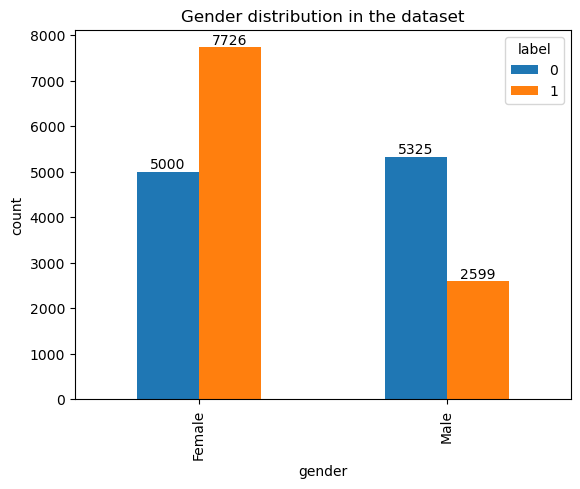

In [51]:
ax = table.plot(kind='bar')


# Display the numbers on the plot
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')

plt.xlabel("gender")
plt.ylabel("count")
plt.title("Gender distribution in the dataset")
plt.show()

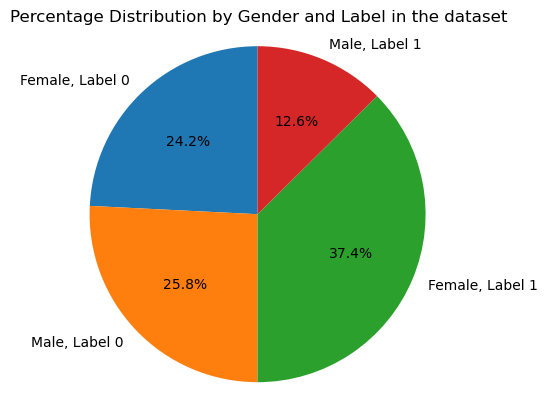

In [121]:
# Grouped data
labels = ['Female, Label 0',  'Male, Label 0', 'Female, Label 1','Male, Label 1']
sizes = grouped['count']
explode = (0, 0, 0, 0)  # No slice will be exploded

# Plotting the pie chart
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Percentage Distribution by Gender and Label in the dataset')

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')

# Display the pie chart
plt.show()

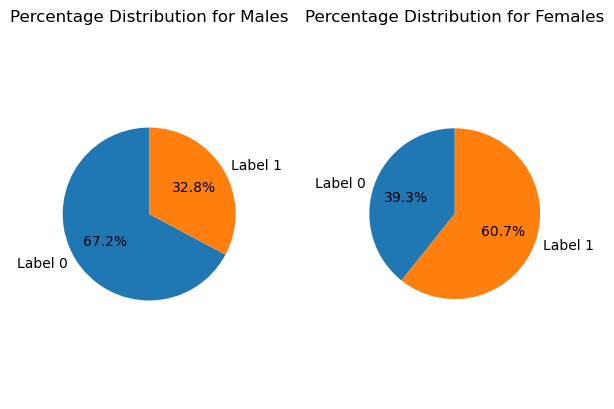

In [53]:
# Filter the data for males and females
male_data = grouped[grouped['gender'] == 'Male']
female_data = grouped[grouped['gender'] == 'Female']

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2)

# Pie chart for males
labels_male = ['Label 0', 'Label 1']
sizes_male = male_data['count']
explode_male = (0, 0)  # No slice will be exploded
axes[0].pie(sizes_male, explode=explode_male, labels=labels_male, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Percentage Distribution for Males')

# Pie chart for females
labels_female = ['Label 0', 'Label 1']
sizes_female = female_data['count']
explode_female = (0, 0)  # No slice will be exploded
axes[1].pie(sizes_female, explode=explode_female, labels=labels_female, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Percentage Distribution for Females')

# Equal aspect ratio ensures that pies are drawn as circles
axes[0].axis('equal')
axes[1].axis('equal')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.6)

# Display the plot
plt.show()

## age

In [30]:
# convert the birthday column to datetime format
df_user['birthday'] = pd.to_datetime(df_user['birthday'], format='%Y-%m-%d', errors='coerce')


C:\Users\lenovo\AppData\Local\Temp\ipykernel_5484\1159511509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['birthday'] = pd.to_datetime(df_user['birthday'], format='%Y-%m-%d', errors='coerce')


In [31]:
# calculate the age of each person and add it as a new column
df_user['age'] = (datetime.now() - df_user['birthday']).astype('<m8[Y]')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5484\3439789093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_user['age'] = (datetime.now() - df_user['birthday']).astype('<m8[Y]')


In [67]:
# Filter the data for label 1 and label 0
label_1_data = df_user[df_user['label'] == 1]
label_0_data = df_user[df_user['label'] == 0]


In [68]:
label_0_data

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count,age
0,25640,0,女,很会害羞,NaT,413,1672,3634,50,32,NaN
1,28303,0,女,我想去一个地方、和你或者是自己看风吹麦浪,NaT,488,145,1969,41,57,NaN
2,10546,0,女,一诚抵万恶,2000-04-26,135,797,148,65,25,23.0
3,26929,0,女,若你喜欢怪人 那我也还不错,NaT,4913,251,712,100,1,NaN
4,31080,0,女,专业丰胸私护达人+卫❤️：tingting395506,1987-10-23,336670,1126,9999,100,0,35.0
...,...,...,...,...,...,...,...,...,...,...,...
10320,32548,0,男,👿,2002-12-12,10,86,1903,16,84,20.0
10321,32551,0,男,无,NaT,9,142,42,10,26,NaN
10322,32553,0,男,只是一个路人粉,NaT,83,164,5523,68,30,NaN
10323,32568,0,男,无,NaT,11,41,6,6,0,NaN


In [69]:
label_0_data

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count,age
0,25640,0,女,很会害羞,NaT,413,1672,3634,50,32,NaN
1,28303,0,女,我想去一个地方、和你或者是自己看风吹麦浪,NaT,488,145,1969,41,57,NaN
2,10546,0,女,一诚抵万恶,2000-04-26,135,797,148,65,25,23.0
3,26929,0,女,若你喜欢怪人 那我也还不错,NaT,4913,251,712,100,1,NaN
4,31080,0,女,专业丰胸私护达人+卫❤️：tingting395506,1987-10-23,336670,1126,9999,100,0,35.0
...,...,...,...,...,...,...,...,...,...,...,...
10320,32548,0,男,👿,2002-12-12,10,86,1903,16,84,20.0
10321,32551,0,男,无,NaT,9,142,42,10,26,NaN
10322,32553,0,男,只是一个路人粉,NaT,83,164,5523,68,30,NaN
10323,32568,0,男,无,NaT,11,41,6,6,0,NaN


In [70]:
# Calculate the age distribution for label 1 and label 0
age_counts_label_1 = label_1_data['age'].value_counts().sort_index()
age_counts_label_0 = label_0_data['age'].value_counts().sort_index()

In [71]:
age_counts_label_0

3.0       8
4.0      42
5.0      66
6.0      42
7.0      42
         ..
118.0     1
119.0     1
120.0     1
122.0    11
123.0    25
Name: age, Length: 87, dtype: int64

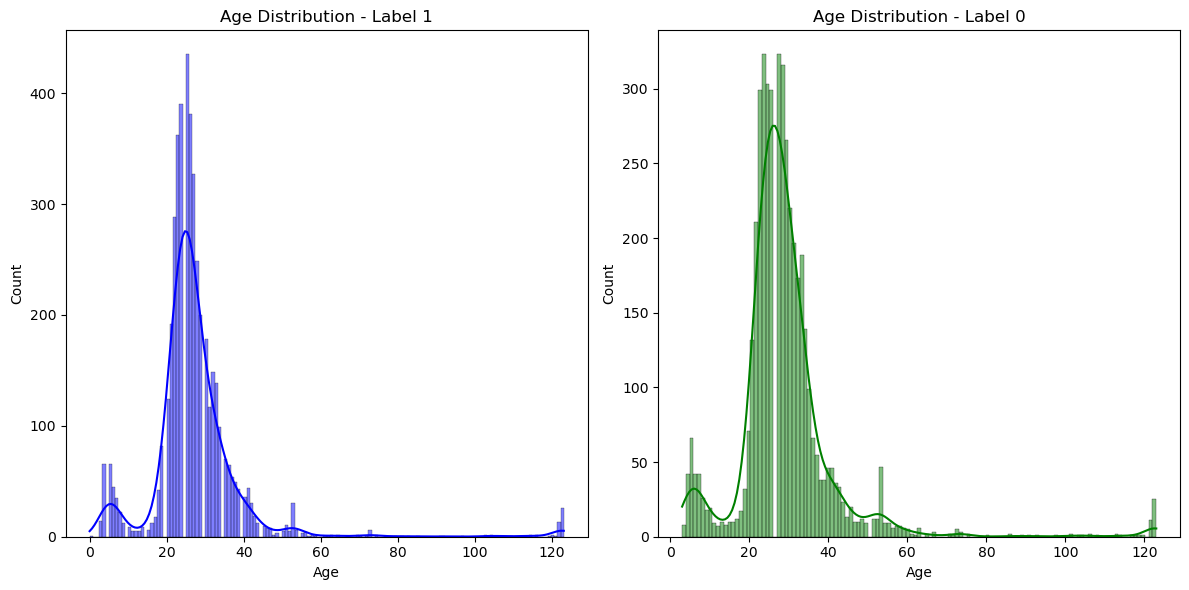

In [72]:

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='age',color='blue', kde=True, ax=axes[0])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')
axes[0].set_title('Age Distribution - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data, x='age', color='green',kde=True, ax=axes[1])
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Count')
axes[1].set_title('Age Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## num_of_follower

In [13]:
label_1_data

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
10325,1,1,男,此人严重丧，不适绕行，谢谢,1993-12-10,1,0,10,10,0
10326,2,1,女,无,1997-06-07,173,76,219,79,70
10327,3,1,女,喜提呼伦贝尔大草原五个月。,无,22,205,6188,24,5
10328,4,1,女,无,无,2,9,62,17,6
10329,5,1,女,无,2001-09-25,1,27,6,6,0
...,...,...,...,...,...,...,...,...,...,...
20645,10321,1,男,无,无,24,2,96,94,2
20646,10322,1,女,🆕,双子座,145,501,2519,21,5
20647,10323,1,女,无,0000-12-03,345,1003,4218,28,1
20648,10324,1,男,教育！科学！学会读书，便是点燃火炬；每个字的每个音节都发射火星。,1981-08-16,243,307,148,24,2


In [14]:
# Calculate the age distribution for label 1 and label 0
follower_counts_label_1 = label_1_data['num_of_follower'].value_counts().sort_index()
follower_counts_label_0 = label_0_data['num_of_follower'].value_counts().sort_index()

In [84]:
follower_counts_label_1

0             9
1           678
2           370
3           241
4           160
           ... 
2068067       1
2436070       1
3477083       1
4107376       1
34215146      1
Name: num_of_follower, Length: 1401, dtype: int64

In [85]:
follower_counts_label_0

0             9
1           309
2           220
3           134
4           115
           ... 
5331448       1
5609453       1
6065603       1
10320878      1
10945046      1
Name: num_of_follower, Length: 2397, dtype: int64

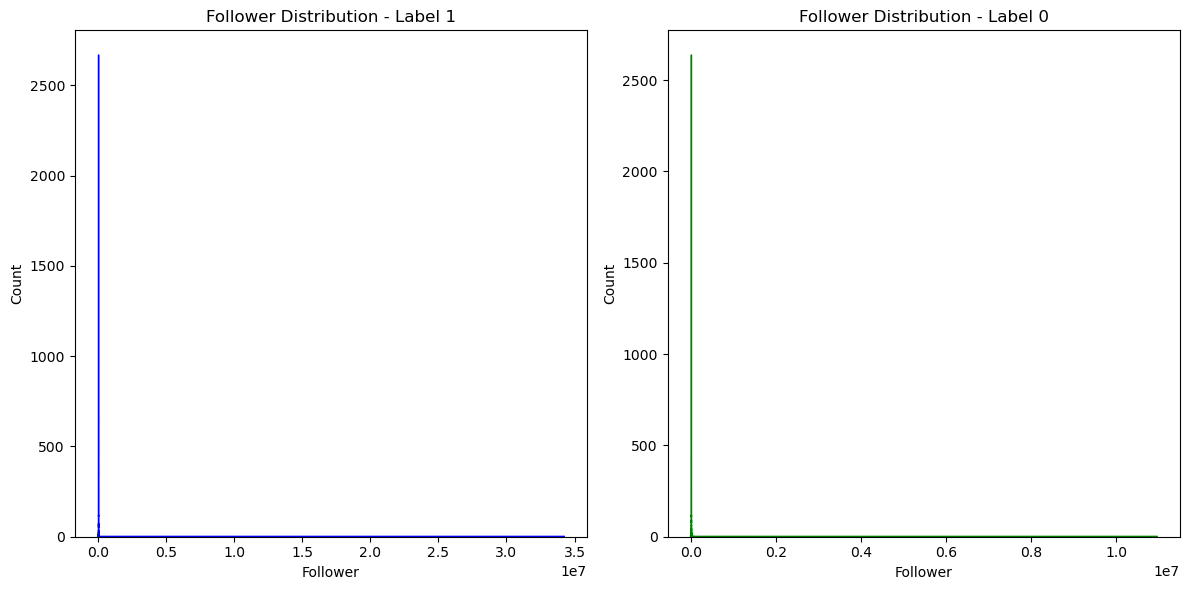

In [61]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='num_of_follower', color='blue', kde=True, ax=axes[0], element='step')
axes[0].set_xlabel('Follower')
axes[0].set_ylabel('Count')
axes[0].set_title('Follower Distribution - Label 1')

# Bar chart for label 0
sns.histplot(data=label_0_data, x='num_of_follower', color='green', kde=True, ax=axes[1], element='step')
axes[1].set_xlabel('Follower')
axes[1].set_ylabel('Count')
axes[1].set_title('Follower Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


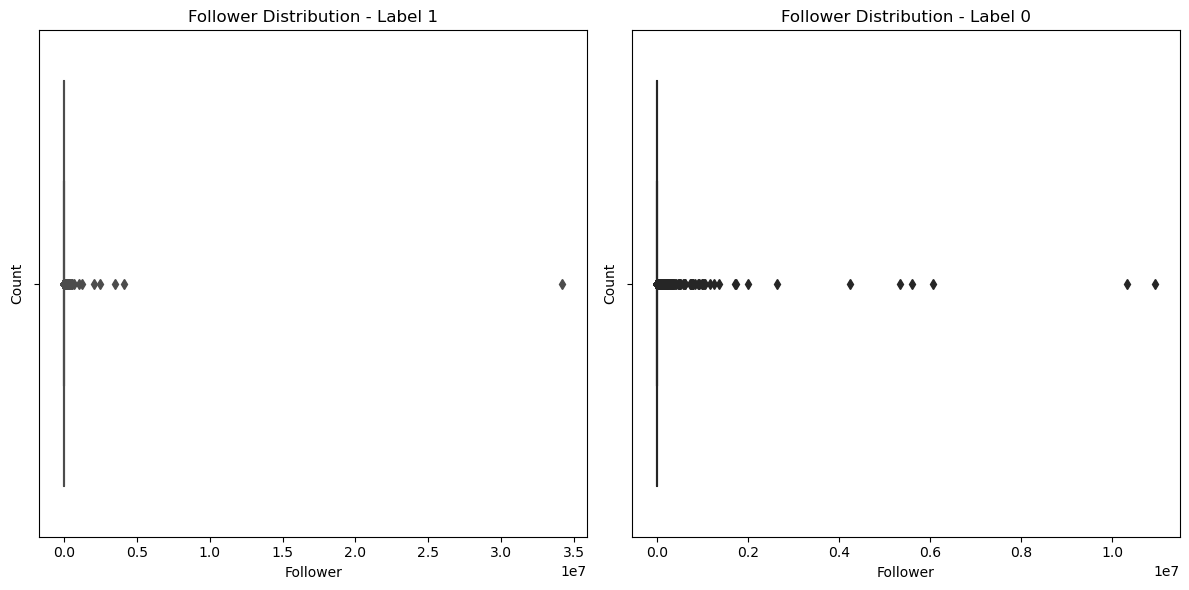

In [86]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Box plot for label 1
sns.boxplot(data=label_1_data, x='num_of_follower', color='blue', ax=axes[0])
axes[0].set_xlabel('Follower')
axes[0].set_ylabel('Count')
axes[0].set_title('Follower Distribution - Label 1')

# Box plot for label 0
sns.boxplot(data=label_0_data, x='num_of_follower', color='green', ax=axes[1])
axes[1].set_xlabel('Follower')
axes[1].set_ylabel('Count')
axes[1].set_title('Follower Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [15]:
# Calculate the interquartile range (IQR) for each label
iqr_label_1 = label_1_data['num_of_follower'].quantile(0.75) - label_1_data['num_of_follower'].quantile(0.25)
iqr_label_0 = label_0_data['num_of_follower'].quantile(0.75) - label_0_data['num_of_follower'].quantile(0.25)

# Define the lower and upper bounds for each label
lower_bound_label_1 = label_1_data['num_of_follower'].quantile(0.25) - 1.5 * iqr_label_1
upper_bound_label_1 = label_1_data['num_of_follower'].quantile(0.75) + 1.5 * iqr_label_1
lower_bound_label_0 = label_0_data['num_of_follower'].quantile(0.25) - 1.5 * iqr_label_0
upper_bound_label_0 = label_0_data['num_of_follower'].quantile(0.75) + 1.5 * iqr_label_0

# Filter out the outliers for each label
label_1_data_no_outliers = label_1_data[(label_1_data['num_of_follower'] >= lower_bound_label_1) & (label_1_data['num_of_follower'] <= upper_bound_label_1)]
label_0_data_no_outliers = label_0_data[(label_0_data['num_of_follower'] >= lower_bound_label_0) & (label_0_data['num_of_follower'] <= upper_bound_label_0)]


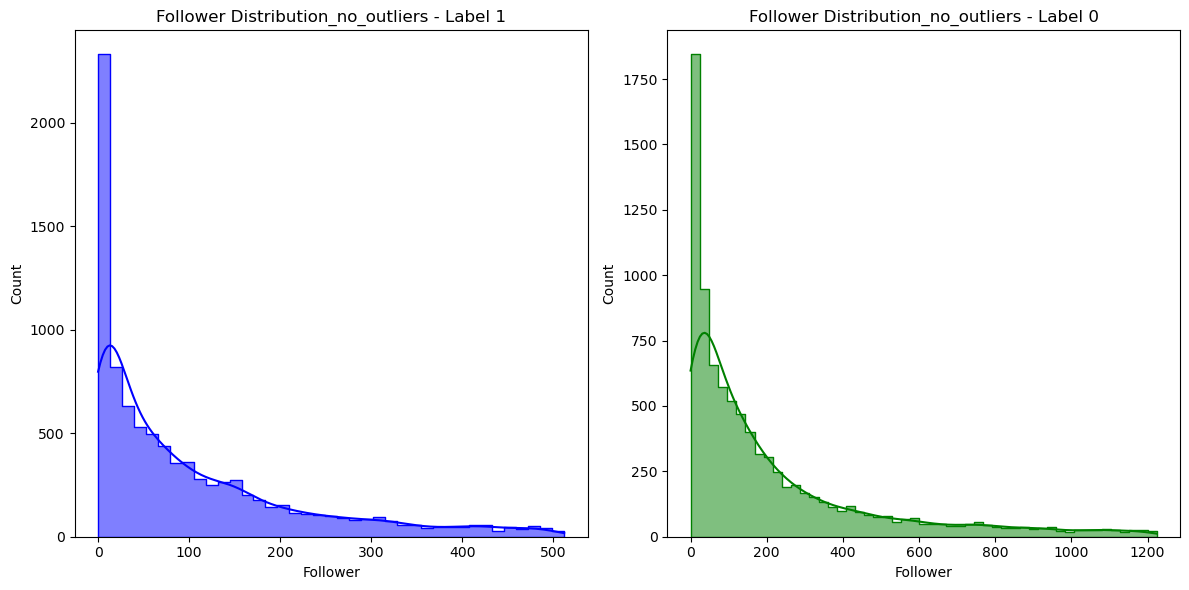

In [16]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data_no_outliers, x='num_of_follower', color='blue', kde=True, ax=axes[0], element='step')
axes[0].set_xlabel('Follower')
axes[0].set_ylabel('Count')
axes[0].set_title('Follower Distribution_no_outliers - Label 1')

# Bar chart for label 0
sns.histplot(data=label_0_data_no_outliers, x='num_of_follower', color='green', kde=True, ax=axes[1], element='step')
axes[1].set_xlabel('Follower')
axes[1].set_ylabel('Count')
axes[1].set_title('Follower Distribution_no_outliers - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


## num_of_following

In [122]:
# Calculate the age distribution for label 1 and label 0
following_counts_label_1 = label_1_data['num_of_following'].value_counts().sort_index()
following_counts_label_0 = label_0_data['num_of_following'].value_counts().sort_index()

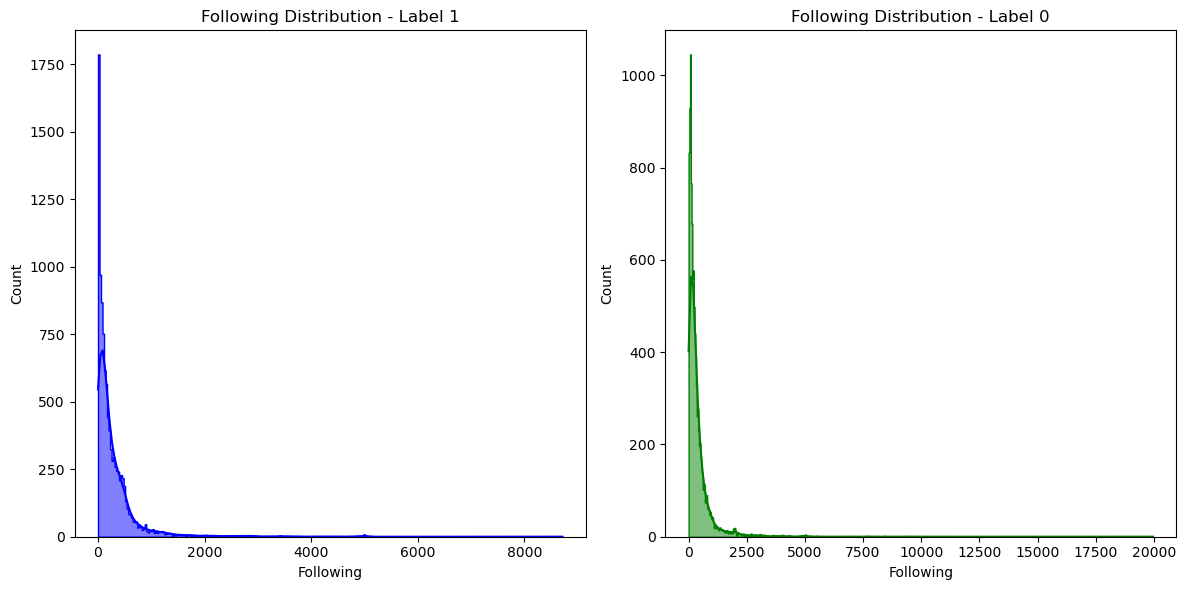

In [123]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='num_of_following',color='blue', kde=True, ax=axes[0], element='step')
axes[0].set_xlabel('Following')
axes[0].set_ylabel('Count')
axes[0].set_title('Following Distribution - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data, x='num_of_following', color='green',kde=True, ax=axes[1], element='step')
axes[1].set_xlabel('Following')
axes[1].set_ylabel('Count')
axes[1].set_title('Following Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## all_tweet_count

In [9]:
# Calculate the age distribution for label 1 and label 0
following_counts_label_1 = label_1_data['all_tweet_count'].value_counts().sort_index()
following_counts_label_0 = label_0_data['all_tweet_count'].value_counts().sort_index()

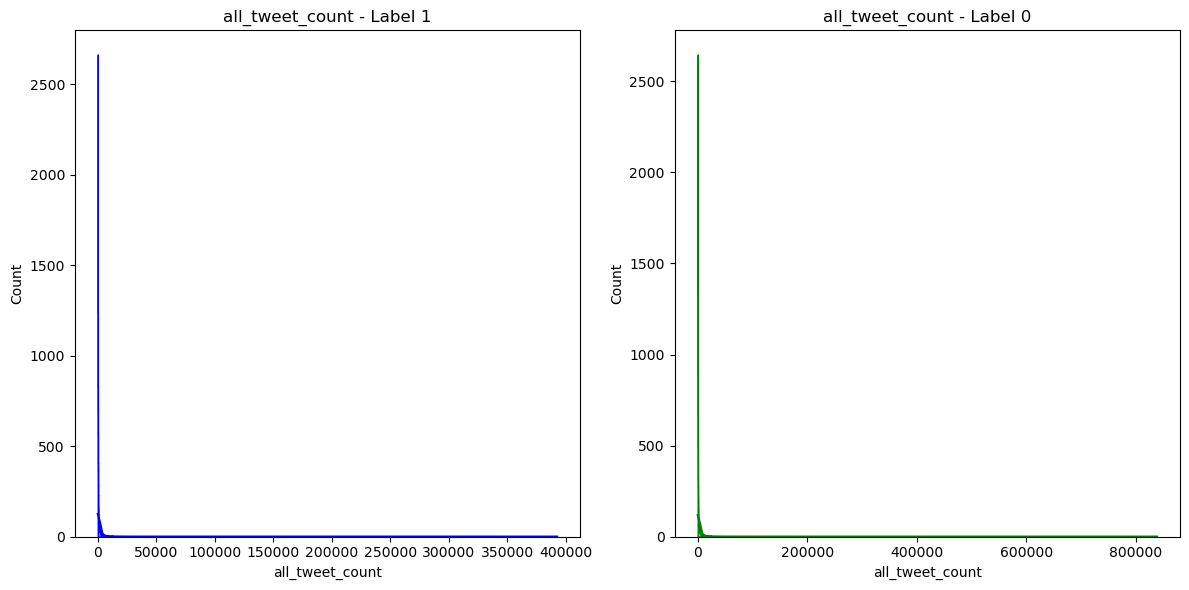

In [125]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='all_tweet_count',color='blue', kde=True, ax=axes[0], element='step')
axes[0].set_xlabel('all_tweet_count')
axes[0].set_ylabel('Count')
axes[0].set_title('all_tweet_count - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data, x='all_tweet_count', color='green',kde=True, ax=axes[1], element='step')
axes[1].set_xlabel('all_tweet_count')
axes[1].set_ylabel('Count')
axes[1].set_title('all_tweet_count - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [10]:
# Calculate the interquartile range (IQR) for each label
iqr_label_1 = label_1_data['all_tweet_count'].quantile(0.75) - label_1_data['all_tweet_count'].quantile(0.25)
iqr_label_0 = label_0_data['all_tweet_count'].quantile(0.75) - label_0_data['all_tweet_count'].quantile(0.25)

# Define the lower and upper bounds for each label
lower_bound_label_1 = label_1_data['all_tweet_count'].quantile(0.25) - 1.5 * iqr_label_1
upper_bound_label_1 = label_1_data['all_tweet_count'].quantile(0.75) + 1.5 * iqr_label_1
lower_bound_label_0 = label_0_data['all_tweet_count'].quantile(0.25) - 1.5 * iqr_label_0
upper_bound_label_0 = label_0_data['all_tweet_count'].quantile(0.75) + 1.5 * iqr_label_0

# Filter out the outliers for each label
label_1_data_no_outliers = label_1_data[(label_1_data['all_tweet_count'] >= lower_bound_label_1) & (label_1_data['all_tweet_count'] <= upper_bound_label_1)]
label_0_data_no_outliers = label_0_data[(label_0_data['all_tweet_count'] >= lower_bound_label_0) & (label_0_data['all_tweet_count'] <= upper_bound_label_0)]


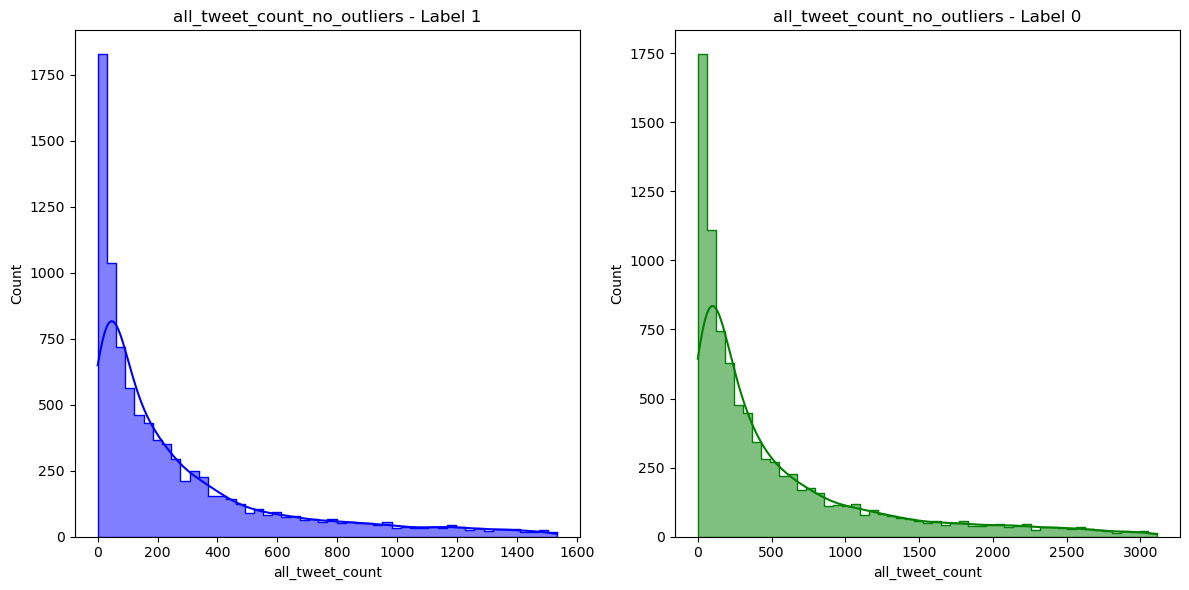

In [12]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data_no_outliers, x='all_tweet_count',color='blue', kde=True, ax=axes[0], element='step')
axes[0].set_xlabel('all_tweet_count')
axes[0].set_ylabel('Count')
axes[0].set_title('all_tweet_count_no_outliers - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data_no_outliers, x='all_tweet_count', color='green',kde=True, ax=axes[1], element='step')
axes[1].set_xlabel('all_tweet_count')
axes[1].set_ylabel('Count')
axes[1].set_title('all_tweet_count_no_outliers - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

##  original_tweet_count

In [17]:
# Calculate the age distribution for label 1 and label 0
original_tweets_counts_label_1 = label_1_data['original_tweet_count'].value_counts().sort_index()
original_tweets_label_0 = label_0_data['original_tweet_count'].value_counts().sort_index()

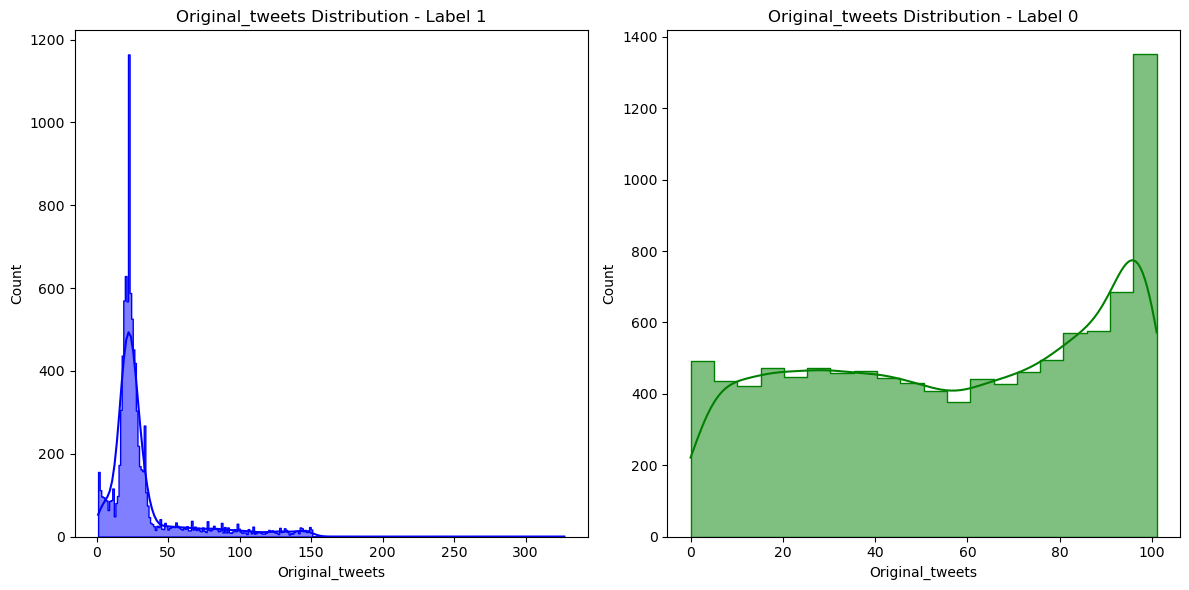

In [18]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='original_tweet_count',color='blue', kde=True, ax=axes[0],element='step')
axes[0].set_xlabel('Original_tweets')
axes[0].set_ylabel('Count')
axes[0].set_title('Original_tweets Distribution - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data, x='original_tweet_count', color='green',kde=True, ax=axes[1],element='step')
axes[1].set_xlabel('Original_tweets')
axes[1].set_ylabel('Count')
axes[1].set_title('Original_tweets Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

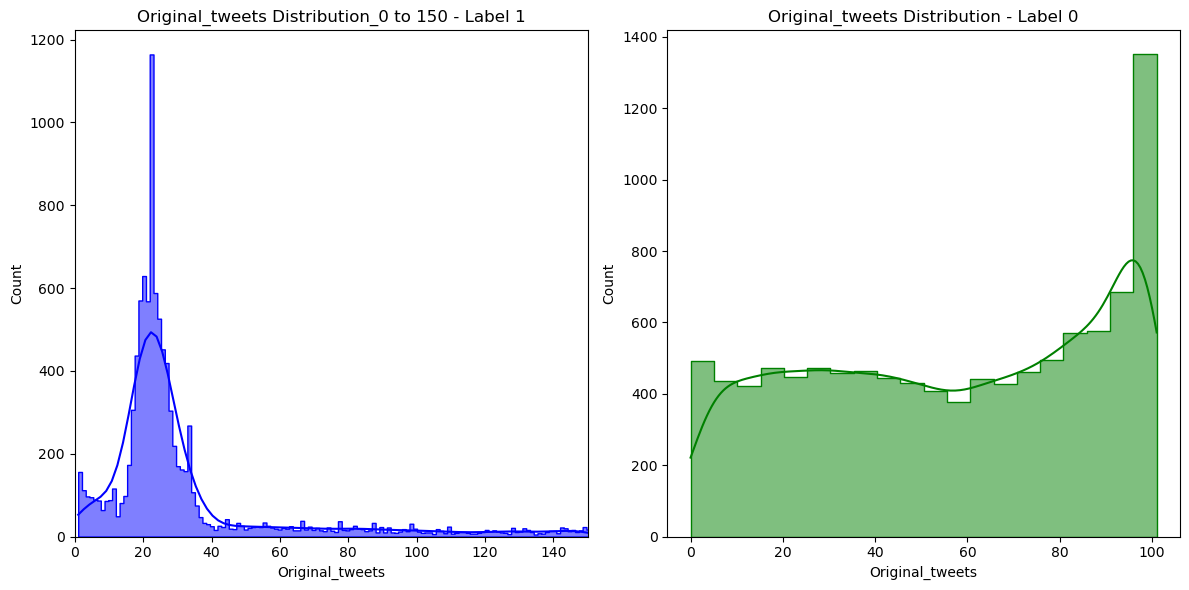

In [25]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='original_tweet_count', color='blue', kde=True, ax=axes[0], element='step')
axes[0].set_xlim(0, 150)  # Set x-axis limit to show only the range of 0-150
axes[0].set_xlabel('Original_tweets')
axes[0].set_ylabel('Count')
axes[0].set_title('Original_tweets Distribution_0 to 150 - Label 1')

# Bar chart for label 0
sns.histplot(data=label_0_data, x='original_tweet_count', color='green', kde=True, ax=axes[1], element='step')
axes[1].set_xlabel('Original_tweets')
axes[1].set_ylabel('Count')
axes[1].set_title('Original_tweets Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()


In [21]:
# Calculate the interquartile range (IQR) for each label
iqr_label_1 = label_1_data['original_tweet_count'].quantile(0.75) - label_1_data['original_tweet_count'].quantile(0.25)
iqr_label_0 = label_0_data['original_tweet_count'].quantile(0.75) - label_0_data['original_tweet_count'].quantile(0.25)

# Define the lower and upper bounds for each label
lower_bound_label_1 = label_1_data['original_tweet_count'].quantile(0.25) - 1.5 * iqr_label_1
upper_bound_label_1 = label_1_data['original_tweet_count'].quantile(0.75) + 1.5 * iqr_label_1
lower_bound_label_0 = label_0_data['original_tweet_count'].quantile(0.25) - 1.5 * iqr_label_0
upper_bound_label_0 = label_0_data['original_tweet_count'].quantile(0.75) + 1.5 * iqr_label_0

# Filter out the outliers for each label
label_1_data_no_outliers = label_1_data[(label_1_data['original_tweet_count'] >= lower_bound_label_1) & (label_1_data['original_tweet_count'] <= upper_bound_label_1)]
label_0_data_no_outliers = label_0_data[(label_0_data['original_tweet_count'] >= lower_bound_label_0) & (label_0_data['original_tweet_count'] <= upper_bound_label_0)]


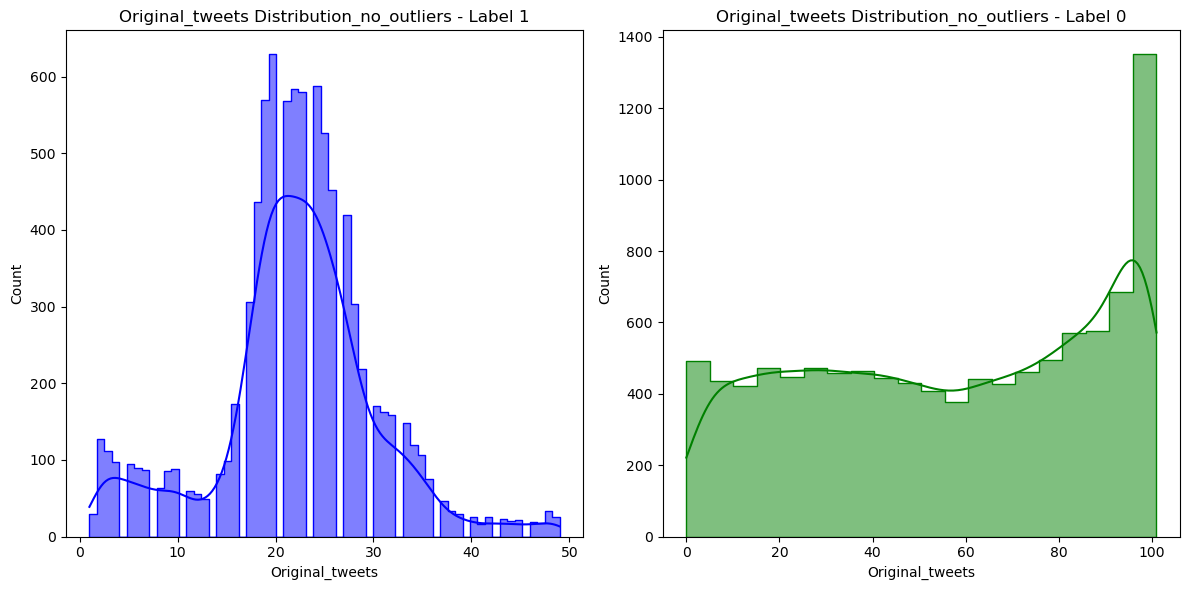

In [23]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data_no_outliers, x='original_tweet_count',color='blue', kde=True, ax=axes[0],element='step')
axes[0].set_xlabel('Original_tweets')
axes[0].set_ylabel('Count')
axes[0].set_title('Original_tweets Distribution_no_outliers - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data_no_outliers, x='original_tweet_count', color='green',kde=True, ax=axes[1],element='step')
axes[1].set_xlabel('Original_tweets')
axes[1].set_ylabel('Count')
axes[1].set_title('Original_tweets Distribution_no_outliers - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

## repost_tweet_count

In [127]:
# Calculate the age distribution for label 1 and label 0
following_counts_label_1 = label_1_data['repost_tweet_count'].value_counts().sort_index()
following_counts_label_0 = label_0_data['repost_tweet_count'].value_counts().sort_index()

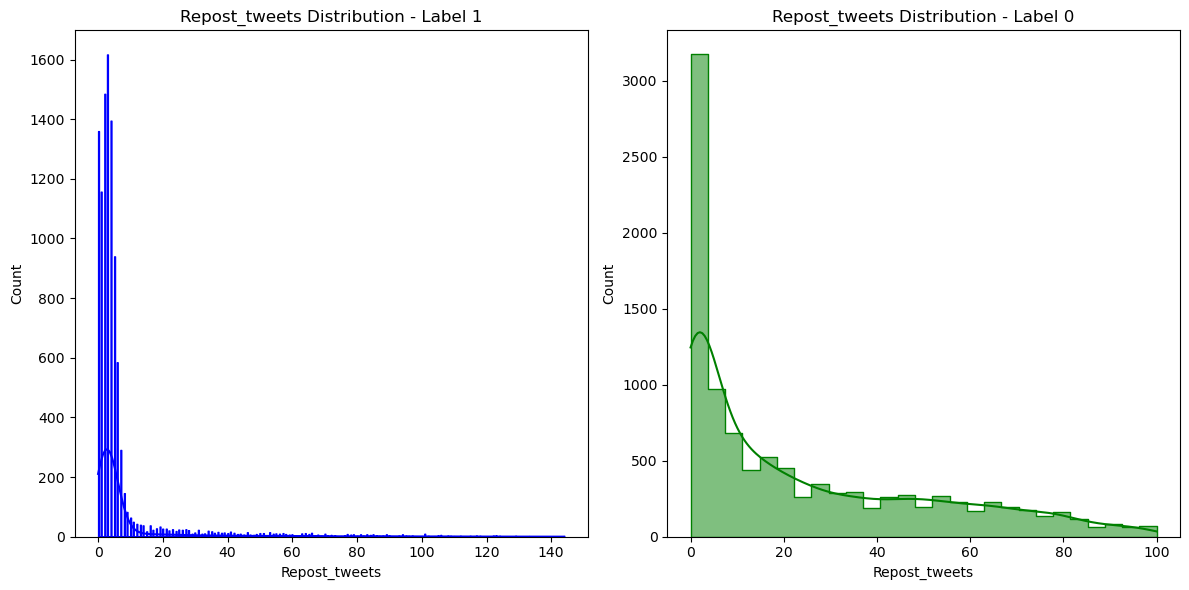

In [128]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for label 1
sns.histplot(data=label_1_data, x='repost_tweet_count',color='blue', kde=True, ax=axes[0],element='step')
axes[0].set_xlabel('Repost_tweets')
axes[0].set_ylabel('Count')
axes[0].set_title('Repost_tweets Distribution - Label 1')



# Bar chart for label 0
sns.histplot(data=label_0_data, x='repost_tweet_count', color='green',kde=True, ax=axes[1],element='step')
axes[1].set_xlabel('Repost_tweets')
axes[1].set_ylabel('Count')
axes[1].set_title('Repost_tweets Distribution - Label 0')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# correlation analysis

In [32]:
df_user

,ID,label,gender,profile,birthday,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count,age
0,25640,0,女,很会害羞,NaT,413,1672,3634,50,32,NaN
1,28303,0,女,我想去一个地方、和你或者是自己看风吹麦浪,NaT,488,145,1969,41,57,NaN
2,10546,0,女,一诚抵万恶,2000-04-26,135,797,148,65,25,23.0
3,26929,0,女,若你喜欢怪人 那我也还不错,NaT,4913,251,712,100,1,NaN
4,31080,0,女,专业丰胸私护达人+卫❤️：tingting395506,1987-10-23,336670,1126,9999,100,0,35.0
...,...,...,...,...,...,...,...,...,...,...,...
20645,10321,1,男,无,NaT,24,2,96,94,2,NaN
20646,10322,1,女,🆕,NaT,145,501,2519,21,5,NaN
20647,10323,1,女,无,NaT,345,1003,4218,28,1,NaN
20648,10324,1,男,教育！科学！学会读书，便是点燃火炬；每个字的每个音节都发射火星。,1981-08-16,243,307,148,24,2,41.0


In [54]:
user_profile=df_user[['age','num_of_follower','num_of_following','all_tweet_count','original_tweet_count','repost_tweet_count']]

In [46]:
user_profile

,age,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
0,NaN,413,1672,3634,50,32
1,NaN,488,145,1969,41,57
2,23.0,135,797,148,65,25
3,NaN,4913,251,712,100,1
4,35.0,336670,1126,9999,100,0
...,...,...,...,...,...,...
20645,NaN,24,2,96,94,2
20646,NaN,145,501,2519,21,5
20647,NaN,345,1003,4218,28,1
20648,41.0,243,307,148,24,2


In [47]:
# Calculate correlation matrix
corr_matrix = user_profile.corr()

In [48]:
corr_matrix

,age,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
age,1.000000,0.025362,0.078426,0.084662,0.025797,0.038145
num_of_follower,0.025362,1.000000,0.017607,0.192685,0.018908,-0.010072
num_of_following,0.078426,0.017607,1.000000,0.203218,0.039139,0.113371
all_tweet_count,0.084662,0.192685,0.203218,1.000000,0.020589,0.076178
original_tweet_count,0.025797,0.018908,0.039139,0.020589,1.000000,-0.066492
repost_tweet_count,0.038145,-0.010072,0.113371,0.076178,-0.066492,1.000000


## heatmap

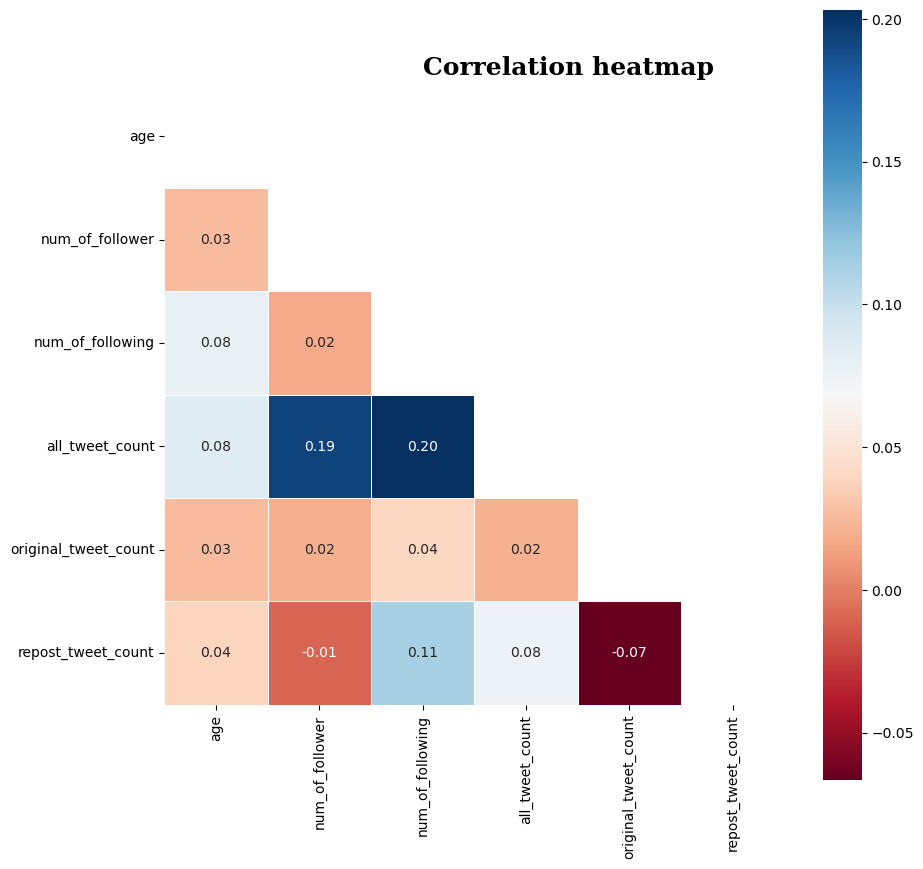

In [49]:
# plot a heatmap
f, ax = plt.subplots(1, 1, figsize=(10, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax.text(2.5, -0.1, 'Correlation heatmap', fontsize=18, fontweight='bold', fontfamily='serif')
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu', 
            square=True, mask=mask, linewidth=0.7, ax=ax)
plt.show()

## point-biserial correlation coefficient. 

The point-biserial correlation coefficient is used to measure the association between a categorical variable with two categories (such as 'label') and a continuous numerical variable.

In [55]:
user_profile=df_user[['label','age','num_of_follower','num_of_following','all_tweet_count','original_tweet_count','repost_tweet_count']]

In [62]:
user_profile

,label,age,num_of_follower,num_of_following,all_tweet_count,original_tweet_count,repost_tweet_count
0,0,28.316855,413,1672,3634,50,32
1,0,28.316855,488,145,1969,41,57
2,0,23.000000,135,797,148,65,25
3,0,28.316855,4913,251,712,100,1
4,0,35.000000,336670,1126,9999,100,0
...,...,...,...,...,...,...,...
20645,1,28.316855,24,2,96,94,2
20646,1,28.316855,145,501,2519,21,5
20647,1,28.316855,345,1003,4218,28,1
20648,1,41.000000,243,307,148,24,2


In [58]:
# Count the number of NaN values in the age column
nan_count = user_profile['age'].isnull().sum()

# Print the result
print(f'There are {nan_count} NaN values in the age column.')

There are 11365 NaN values in the age column.


In [60]:
# Calculate the mean of the age column
age_mean = user_profile['age'].mean()

# Print the result
print(f'The mean of the age column is {age_mean:.2f}.')

The mean of the age column is 28.32.


In [61]:
# Fill the NaN values in the age column with the mean of the column
user_profile['age'] = user_profile['age'].fillna(user_profile['age'].mean())

C:\Users\lenovo\AppData\Local\Temp\ipykernel_5484\631618092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_profile['age'] = user_profile['age'].fillna(user_profile['age'].mean())


In [63]:

# Create a list of numerical variables
num_vars = ['age','num_of_follower','num_of_following','all_tweet_count','original_tweet_count','repost_tweet_count']

# Loop through the list and calculate the point-biserial correlation coefficient for each variable with label
for var in num_vars:
  # Use the pointbiserialr function from stats module
  # The first argument is the categorical variable (label)
  # The second argument is the numerical variable (var)
  r, p = stats.pointbiserialr(user_profile['label'], user_profile[var])
  # Print the results
  print(f'The point-biserial correlation coefficient between label and {var} is {r:.3f} with a p-value of {p:.3f}')


The point-biserial correlation coefficient between label and age is -0.037 with a p-value of 0.000
The point-biserial correlation coefficient between label and num_of_follower is -0.008 with a p-value of 0.252
The point-biserial correlation coefficient between label and num_of_following is -0.079 with a p-value of 0.000
The point-biserial correlation coefficient between label and all_tweet_count is -0.064 with a p-value of 0.000
The point-biserial correlation coefficient between label and original_tweet_count is -0.367 with a p-value of 0.000
The point-biserial correlation coefficient between label and repost_tweet_count is -0.354 with a p-value of 0.000


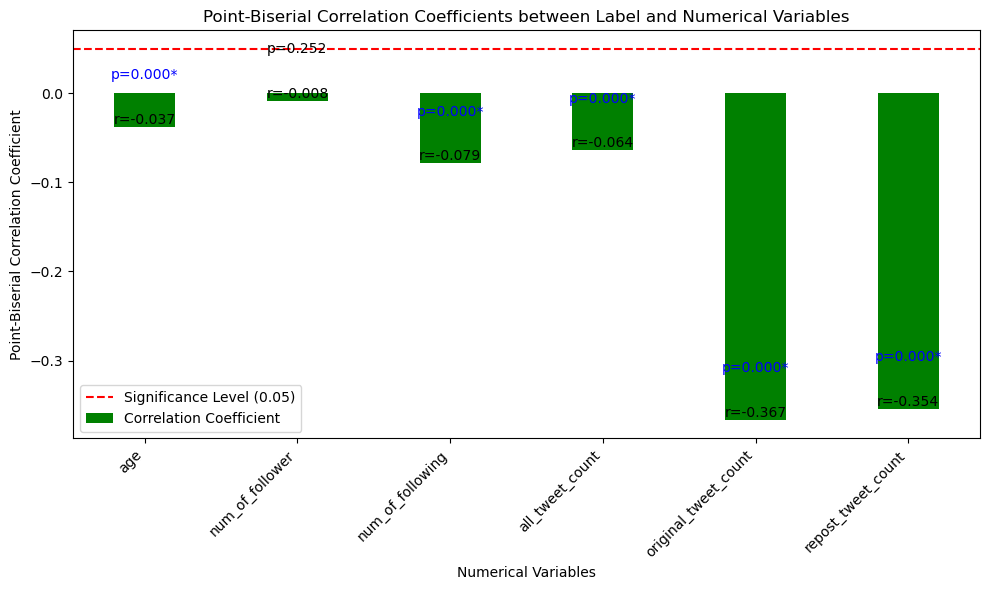

In [84]:
# Create a list of numerical variables
num_vars = ['age', 'num_of_follower', 'num_of_following', 'all_tweet_count', 'original_tweet_count', 'repost_tweet_count']

# Initialize lists to store correlation coefficients and p-values
correlation_coeffs = []
p_values = []

# Calculate point-biserial correlation coefficients and p-values
for var in num_vars:
    r, p = stats.pointbiserialr(user_profile['label'], user_profile[var])
    correlation_coeffs.append(r)
    p_values.append(p)

# Create a figure and axis for the bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot with error bars representing confidence intervals
x_pos = np.arange(len(num_vars))
bar_width = 0.4
bars = ax.bar(x_pos, correlation_coeffs, bar_width, color='g', label='Correlation Coefficient')

# Set x-axis labels and title
ax.set_xticks(x_pos)
ax.set_xticklabels(num_vars, rotation=45, ha='right')
ax.set_xlabel('Numerical Variables')
ax.set_ylabel('Point-Biserial Correlation Coefficient')
ax.set_title('Point-Biserial Correlation Coefficients between Label and Numerical Variables')

# Add the significance level indicator
sig_level = 0.05
ax.axhline(sig_level, color='r', linestyle='--', label='Significance Level (0.05)')

# Add the legend
ax.legend()

# Add correlation coefficient numbers and p-values above each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'r={correlation_coeffs[i]:.3f}', ha='center', va='bottom', fontsize=10)
    p_val = p_values[i]
    if p_val <= sig_level:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'p={p_val:.3f}*', ha='center', va='bottom', fontsize=10, color='blue')
    else:
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'p={p_val:.3f}', ha='center', va='bottom', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

# Word cloud

In [85]:
balanced_df_all_cleaned_tokenization = pd.read_csv('balanced_df_all_cleaned_tokenization.csv')

In [86]:
df = balanced_df_all_cleaned_tokenization.copy()

In [87]:
df

,ID,label,tweet_content
0,25640,0,害真 挺 吃 颜想 岁 足 表达 减肥 决心 姐妹 谈恋爱 感觉 全世界 闺蜜 介绍 成功 ...
1,28303,0,拥抱 世界 暖心 动作 生活 中 难免 挫折 坎坷 安 慌乱 许 拥抱 充满 量 世界 抗衡...
2,10546,0,雨天 穿 滑倒 坐水里 亲测 艾特子 赟 家 意见 麻雀 妈妈 问 麻雀 扎 头发 麻雀 说...
3,26929,0,幸福 做 桌菜 然家 朋友 吃 完 没 帮忙 刷碗 老规矩 昨晚 想 做 早餐 奶包 发酵 ...
4,31080,0,日 清明 青草 疫情 中 牺牲 医护 员 公安干警 基层干部 线 工作 逝世 胞 沉痛 悼念...
...,...,...,...
20645,10321,1,意做件 错事 真 久久 原谅 近 发生 事 情绪 波动 房间 爆哭然 雨天 跑 出 外面 冻...
20646,10322,1,太 喜欢 张 教授 说话 特实 危言耸听 然 整体 医生 亲戚朋友 医生 医生 子女 微博 ...
20647,10323,1,毒药 断送 爱 听说 爱情 蜜糖 深陷 沉醉 岂知 份 爱情 美意 想 原理 结束 意想 称...
20648,10324,1,果 原谅 痛苦 值 降低 贼 悔 吃 麻辣 串 洗完 澡 新 换衣服 全味 难受 新闻 男 ...


Text(0.5, 1.0, "Word cloud of depressed users' tweets")

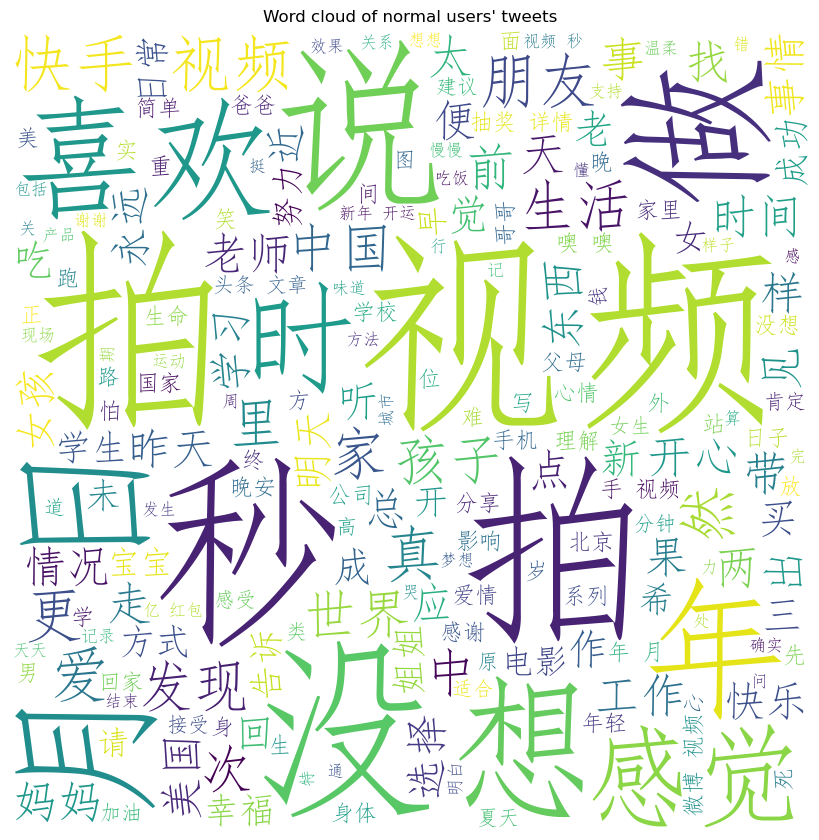

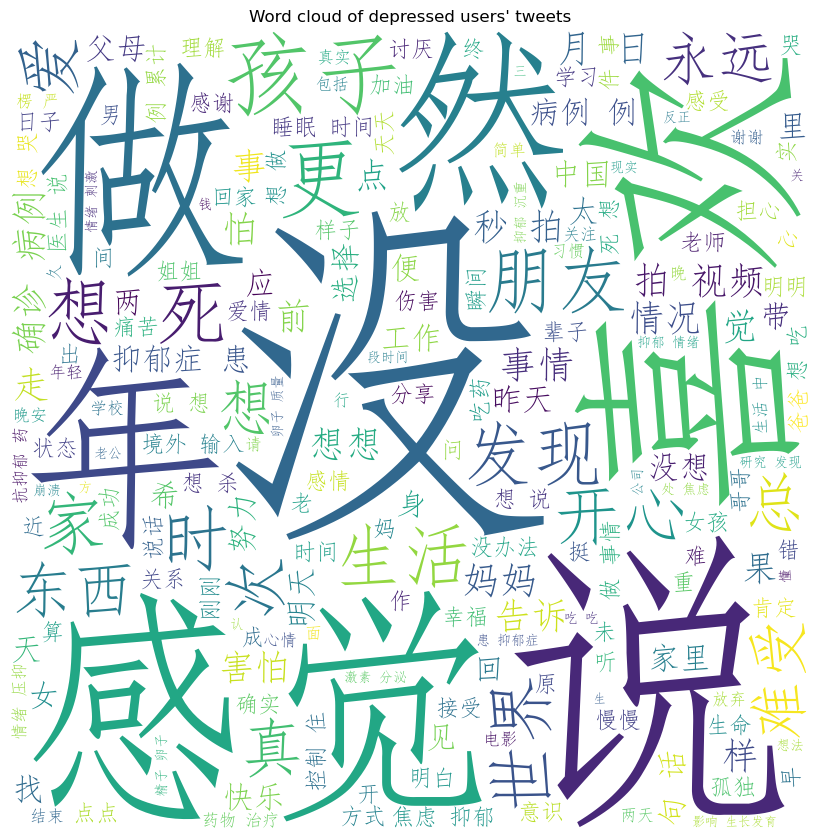

In [89]:
# Create a word cloud for label 0
text = ' '.join(map(str, df[df['label'] == 0]['tweet_content']))
# text = ' '.join(df[df['label'] == 0]['tweet_content'])
font_path = r'C:\Windows\Fonts\simfang.ttf'#设置中文字体，否则词云图可能不显示中文
wordcloud = WordCloud(width=800, height=800, background_color='white',font_path=font_path).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word cloud of normal users' tweets")

# Create a word cloud for label 1
text = ' '.join(map(str, df[df['label'] == 1]['tweet_content']))
# text = ' '.join(df[df['label'] == 1]['tweet_content'])
wordcloud = WordCloud(width=800, height=800, background_color='white',font_path=font_path).generate(text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word cloud of depressed users' tweets")

In [93]:
from collections import Counter
# Get word frequencies
words = wordcloud.process_text(text)
# Get the 10 most frequent words and their frequencies
most_common_words = Counter(words).most_common(10)

# Print the 10 most frequent words and their frequencies
print("Most frequent words and their frequencies:")
for word, frequency in most_common_words:
    print(f"{word}: {frequency}")

Most frequent words and their frequencies:
没: 15641
说: 13811
感觉: 10430
喜欢: 9860
做: 8973
年: 8225
然: 8064
孩子: 6589
更: 6532
想 死: 6193


10 Most Frequent Words in Normal Users' Tweets:
拍 视频: 27993
秒 拍: 24628
没: 21308
说: 19724
做: 14973
想: 14057
月 日: 14057
年: 13676
喜欢: 13622
时: 10955


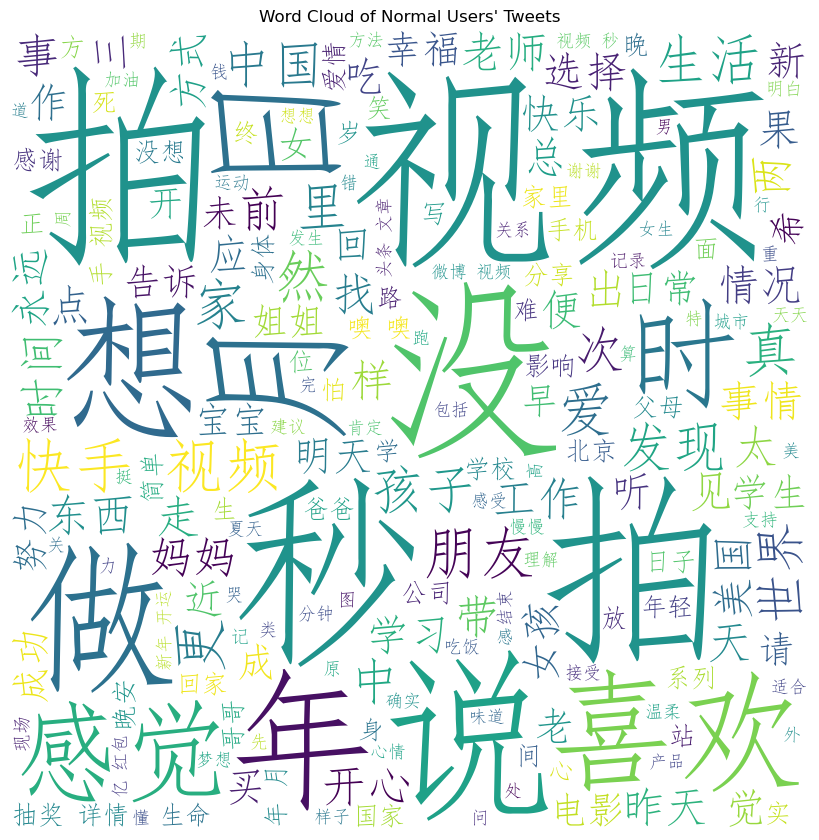

10 Most Frequent Words in Depressed Users' Tweets:
没: 15641
说: 13811
感觉: 10430
喜欢: 9860
做: 8973
年: 8225
然: 8064
孩子: 6589
更: 6532
想 死: 6193


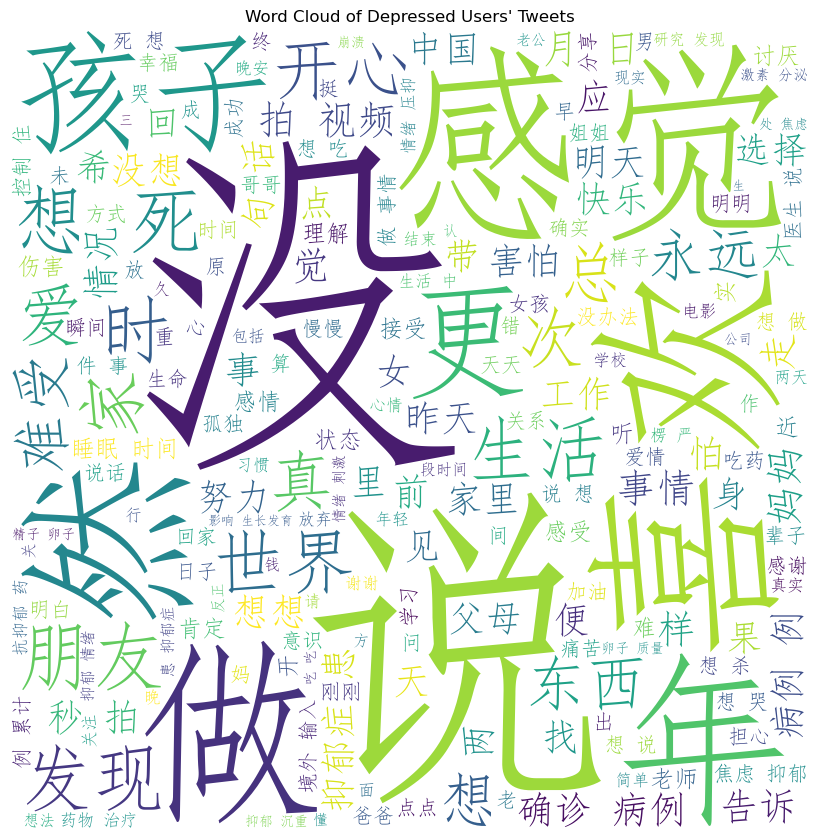

In [95]:
# Create a word cloud for label 0
text_label_0 = ' '.join(map(str, df[df['label'] == 0]['tweet_content']))
font_path = r'C:\Windows\Fonts\simfang.ttf'  # Set the font path for displaying Chinese characters
wordcloud_label_0 = WordCloud(width=800, height=800, background_color='white', font_path=font_path).generate(text_label_0)

# Get the word frequencies for label 0
word_frequencies_label_0 = wordcloud_label_0.process_text(text_label_0)
sorted_word_frequencies_label_0 = sorted(word_frequencies_label_0.items(), key=lambda x: x[1], reverse=True)

# Print the 10 most frequent words and their frequencies for label 0
print("10 Most Frequent Words in Normal Users' Tweets:")
for word, frequency in sorted_word_frequencies_label_0[:10]:
    print(f"{word}: {frequency}")

# Plot the word cloud for label 0
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_label_0)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud of Normal Users' Tweets")

# Show the word cloud for label 0
plt.show()

# Create a word cloud for label 1
text_label_1 = ' '.join(map(str, df[df['label'] == 1]['tweet_content']))
wordcloud_label_1 = WordCloud(width=800, height=800, background_color='white', font_path=font_path).generate(text_label_1)

# Get the word frequencies for label 1
word_frequencies_label_1 = wordcloud_label_1.process_text(text_label_1)
sorted_word_frequencies_label_1 = sorted(word_frequencies_label_1.items(), key=lambda x: x[1], reverse=True)

# Print the 10 most frequent words and their frequencies for label 1
print("10 Most Frequent Words in Depressed Users' Tweets:")
for word, frequency in sorted_word_frequencies_label_1[:10]:
    print(f"{word}: {frequency}")

# Plot the word cloud for label 1
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_label_1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud of Depressed Users' Tweets")

# Show the word cloud for label 1
plt.show()

In [100]:
# Print the 30 most frequent words and their frequencies for label 0
print("30 Most Frequent Words in Normal Users' Tweets:")
for word, frequency in sorted_word_frequencies_label_0[:30]:
    print(f"{word}: {frequency}")

# Print the 30 most frequent words and their frequencies for label 1
print("30 Most Frequent Words in Depressed Users' Tweets:")
for word, frequency in sorted_word_frequencies_label_1[:30]:
    print(f"{word}: {frequency}")

30 Most Frequent Words in Normal Users' Tweets:
拍 视频: 27993
秒 拍: 24628
没: 21308
说: 19724
做: 14973
想: 14057
月 日: 14057
年: 13676
喜欢: 13622
时: 10955
感觉: 10755
快手 视频: 10297
真: 9869
更: 9441
然: 9348
爱: 9260
朋友: 9058
家: 8596
生活: 8331
发现: 8102
里: 8090
中国: 7627
中: 7528
世界: 7426
孩子: 7364
次: 6800
前: 6647
带: 5978
事: 5953
两: 5807
30 Most Frequent Words in Depressed Users' Tweets:
没: 15641
说: 13811
感觉: 10430
喜欢: 9860
做: 8973
年: 8225
然: 8064
孩子: 6589
更: 6532
想 死: 6193
朋友: 5813
时: 5708
发现: 5609
世界: 5526
生活: 5458
家: 5303
开心: 5175
爱: 4822
次: 4731
真: 4731
总: 4545
东西: 4501
难受: 4454
想: 4338
永远: 4311
拍 视频: 4299
妈妈: 4292
走: 4275
月 日: 4269
事情: 4183


# mode;s result

In [72]:
models_results= pd.read_csv('models_results.csv')

In [98]:
# Use the round() function to retain three decimal places
models_results = models_results.round(3)

In [73]:
models_results

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest,0.962389023,0.964998364,0.959037711,0.962008805
1,Multi-layer Perceptron,0.939467312,0.970517655,0.907371795,0.937883054
2,Support Vector Machine,0.947861178,0.987452074,0.908012821,0.946067791
3,TextCNN,0.964326069,0.97472564,0.952860858,0.963669242
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,Model,Accuracy,Precision,Recall,F1 Score
7,Random Forest,96.24%,96.50%,95.90%,96.20%
8,Multi-layer Perceptron,93.95%,97.05%,90.74%,93.79%
9,Support Vector Machine,94.79%,98.75%,90.80%,94.61%


In [109]:
# Set 'Model' column as the index
models_results.set_index('Model', inplace=True)


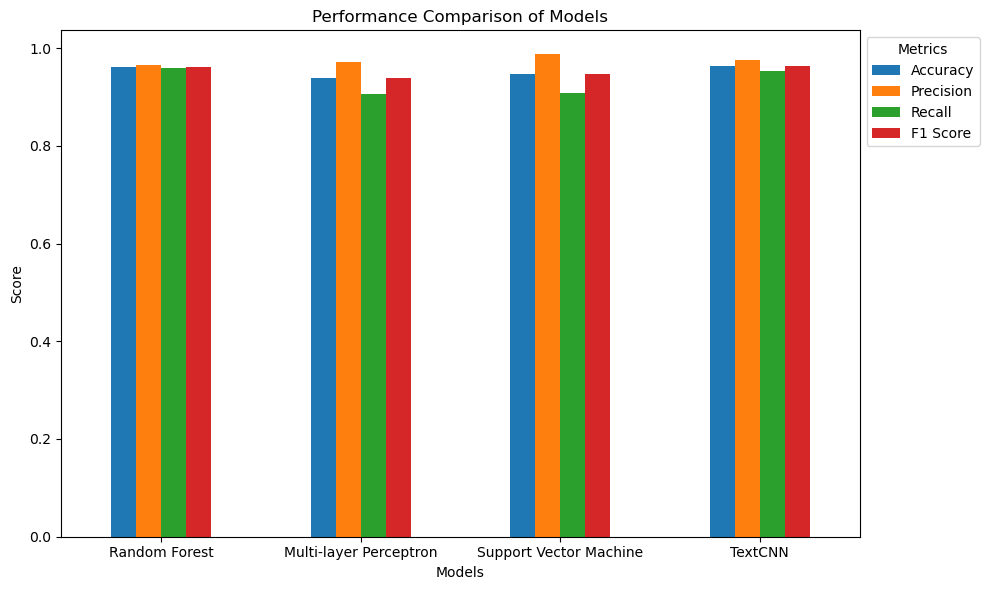

In [117]:
# Plot the bar chart and table
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bar chart
models_results.plot(kind='bar', rot=0, ax=ax)
plt.title('Performance Comparison of Models')
plt.xlabel('Models')
plt.ylabel('Score')
plt.legend(title='Metrics', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()